In [ ]:
# If needed, uncomment the following line and run
#pip install pyjanitor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 4.7 MB/s eta 0:00:00


In [ ]:
# If needed, uncomment the following line and run
#pip install ray

In [ ]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors
from matplotlib.cbook import boxplot_stats
import janitor # run above cell if "no module named janitor"
import datetime

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

from ray import tune
from ray.air import session
from functools import partial

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


device(type='cuda')

In [ ]:
def join_and_clean_datasets(mds3_df, demo_df, age_sex_df, min_visits):

  # Filter for patients who have a 'BL' visit
  patno_w_bl = mds3_df[mds3_df['EVENT_ID'] == 'BL']['PATNO'].unique()
  mds3_df = mds3_df[mds3_df['PATNO'].isin(patno_w_bl)]

  # Filter for events with ID only in visit_ids (not sure if we should include other visit types, so filter out for now)
  visit_time_dict = {'BL':0.,
                    'V01':3.,
                    'V02':6.,
                    'V03':9.,
                    'V04':12.,
                    'V05':18.,
                    'V06':24.,
                    'V07':30.,
                    'V08':36.,
                    'V09':42.,
                    'V10':48.,
                    'V11':54.,
                    'V12':60.}#,
                    #'V13':72.,
                    #'V14':84.,
                    #'V15':96.}
              #, 'V16', 'V17', 'V18', 'V19', 'V20'(since we are using the protocol-listed time of visit for now, we don't know when these visits occur)
  visit_ids = list(visit_time_dict.keys())
  mds3_df = mds3_df[mds3_df['EVENT_ID'].isin(visit_ids)]

  # Order by visit_ids and TMS
  # (order by TMS so that, when duplicates occur, we can take the last, i.e. max, TMS)
  mds3_df['EVENT_ID'] = pd.Categorical(mds3_df['EVENT_ID'], categories = visit_ids, ordered = True)
  mds3_df = mds3_df.sort_values(['PATNO', 'EVENT_ID', 'NP3TOT'])

  # Subset the columns we want
  columns = ['PATNO', 'EVENT_ID', 'EXAMDT', 'NP3FACXP', 'NP3RIGN',
            'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR',
            'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL',
            'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG',
            'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY',
            'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU',
            'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON',
            'NP3TOT']
  df2 = mds3_df[mds3_df.columns.intersection(columns)]

  # Remove rows with duplicate visits (QUESTION: do we want to filter differently? E.g. for duplicate entries keep only medication "off" measurements?)
  df2 = df2.drop_duplicates(subset = ['PATNO', 'EVENT_ID'], keep = 'last')

  # Remove any rows with NaN (these correspond to visits that occured but are missing data,
  # not visits that did not occur)
  df2 = df2.dropna()

  # Filter for patients with fewer than MIN_VISITS visits
  grouped = df2[['PATNO', 'EVENT_ID']].groupby(by = 'PATNO')
  for name, df in grouped:
    nrow = len(df)
    if nrow < min_visits:
      df2 = df2[df2["PATNO"] != name]

  # Add in visits from `visit_time_dict` which each patient has missed
  df2 = df2.complete(
      'PATNO',
      {'EVENT_ID':list(visit_time_dict.keys())}
  )

  # Fill in the motor scores of new rows with values of -1.0
  cols_to_fill = [col for col in df2.columns if col not in ['PATNO', 'EVENT_ID', 'AGE_AT_BL', 'SEX']]
  df2[cols_to_fill] = df2[cols_to_fill].fillna(-1.0)

  # Map 'EVENT_ID' to 'YEARS_SINCE_BL' (divide by 12 to convert months to years)
  df2['YEARS_SINCE_BL'] = df2['EVENT_ID'].map(visit_time_dict) / 12

  # Add subject age at baseline
  birthday_dict = dict(zip(age_sex_df.PATNO, pd.to_datetime(age_sex_df.BIRTHDT)));
  df2['BIRTHDT'] = df2['PATNO'].map(birthday_dict)
  patno_bldate = df2[df2['EVENT_ID'] == 'BL'][['PATNO', 'EXAMDT']]
  bldate_dict = dict(zip(patno_bldate.PATNO, pd.to_datetime(patno_bldate.EXAMDT)));
  df2['BLDT'] = df2['PATNO'].map(bldate_dict)
  # Divide age at BL by 100 to scale to other parameters
  df2['AGE_AT_BL_DIV_100'] = ((df2['BLDT'] - df2['BIRTHDT']) / np.timedelta64(1, 'Y')).to_numpy() / 100

  # Add subject sex
  sex_dict = dict(zip(age_sex_df.PATNO, age_sex_df.SEX))
  df2['SEX'] = df2['PATNO'].map(sex_dict).astype(np.float32)
  # Remove temporary columns (no longer in use)
  df2 = df2.drop(['BIRTHDT', 'BLDT'], axis = 1)

  # Reorder columns
  new_cols = [columns[0]] + ['YEARS_SINCE_BL'] + ['AGE_AT_BL_DIV_100'] + ['SEX'] + columns[3:]
  df2 = df2[new_cols]

  return df2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define dataframe to sequence function
# Each sequence is a sliding window across a subject's clinical history, containing motor scores at each visit
# E.g. if a subject has 8 visits, and the sequence size is 4, the sequences will be as follows:
  # Sequence 1: [BL, V01, V02, V03], target TMS corresponds to visit V04
  # Sequence 2: [V01, V02, V03, V04], target TMS corresponds to visit V05
  # ...
  # Sequence 5: [V04, V05, V06, V07], target TMS corresponds to visit V08
# Each sequence will be an input to the MLP

def to_sequences(seq_size, obs, n_features_per_visit, n_visit_after_seq_to_target):
  # Empty tensors to store all sequences and targets
  x = torch.empty((0, seq_size * n_features_per_visit + 1))
  y = torch.empty((0, 1))
  # Array to store visit times corresponding to targets
  target_times = []
  # Array to store all (non-target) visit times in the sequence
  all_seq_times = []
  all_seq_tms = []

  # Extract all the rows of patient's dataset where the TMS is valid (non-missing)
  non_missing_obs = obs.loc[obs['NP3TOT'] != -1]

  # Extract all true tms
  all_tms = non_missing_obs['NP3TOT'].to_numpy()

  # Iterate through the non-missing visit dataframe
  for i in range(len(non_missing_obs) - seq_size - n_visit_after_seq_to_target + 1):

    window = non_missing_obs[i:(i + seq_size)] # Observations in sequence
    target_after_window = non_missing_obs[(i + seq_size + n_visit_after_seq_to_target - 1):(i+seq_size + n_visit_after_seq_to_target)]["NP3TOT"].to_numpy() # Target TMS

    seq_times = window['YEARS_SINCE_BL'].to_numpy()
    all_seq_times.append(list(seq_times))

    seq_tms = window['NP3TOT'].to_numpy()
    all_seq_tms.append(list(seq_tms))

    # Now that we've extracted the tms from the window, let's remove it since it adds
    # no new information as model input (it is the sum of other features)
    #window = window.drop(['NP3TOT'], axis = 1)

    # Convert the window to a flattened tensor
    np_window = window.to_numpy()
    tensor_window = torch.tensor(np_window, dtype=torch.float32)
    flattened_window = torch.flatten(tensor_window).view(1, seq_size * n_features_per_visit)

    # Extract the target time of the window (the TMS score immediately after the window)
    target_time = non_missing_obs[(i + seq_size + n_visit_after_seq_to_target - 1):(i+seq_size + n_visit_after_seq_to_target)]["YEARS_SINCE_BL"].to_numpy()[0]
    target_times.append(target_time)
    target_time = torch.tensor(target_time, dtype=torch.float32).view(1, 1)

    # Append the target time to the flattened window
    flattened_window = torch.cat((flattened_window, target_time), 1)
    # Concatendate the window with the tensor of all windows, do the same with target time
    x = torch.cat((x, flattened_window), 0)
    target_after_window = torch.tensor(target_after_window, dtype=torch.float32).view(1, 1)
    y = torch.cat((y, target_after_window), 0)

  return x, y, target_times, all_seq_times, all_seq_tms, all_tms

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def sequence_data(df2, p_train, sequence_size, num_features_per_visit, num_features_per_sequence, n_visit_after_seq_to_target, hyper_parameter_bool):

  if hyper_parameter_bool:
    # Ensures that we produce the same test and training sets on each run, for hyperparameter tuning
    torch.manual_seed(0)

  # Form training and testinput sequences and targets out of dataframe
  unique_patnos = df2['PATNO'].unique()

  # Split into training and test sets of patnos
  n_patnos = len(unique_patnos)
  train_idx = torch.randperm(n_patnos)[:int(n_patnos * p_train)]
  train_patnos = unique_patnos[train_idx]
  test_and_val_patnos = unique_patnos[np.setdiff1d(range(len(unique_patnos)), train_idx)]
  test_idx = np.random.choice(len(test_and_val_patnos), size = 2, replace = False)
  test_patnos = test_and_val_patnos[test_idx]
  val_patnos = test_and_val_patnos[~test_idx]

  X_forecast_train = torch.empty((0, num_features_per_sequence))
  Y_forecast_train = torch.empty((0, 1))
  X_forecast_test = torch.empty((0, num_features_per_sequence))
  Y_forecast_test = torch.empty((0, 1))
  X_forecast_val = torch.empty((0, num_features_per_sequence))
  Y_forecast_val = torch.empty((0, 1))

  grouped = df2.groupby(by = 'PATNO')

  # Dictionaries to store test patient sequences by patno
  val_pat_seq_dict_X = {}
  val_pat_seq_dict_Y = {}
  val_pat_seq_dict_all_tms = {}
  val_pat_seq_dict_seq_times = {}
  val_pat_seq_dict_seq_tms = {}
  val_pat_seq_dict_target_times = {}
  val_pat_seq_dict_true_TMS = {}
  val_pat_seq_dict_age = {}
  val_pat_seq_dict_sex = {}

  for name, df in grouped:

    if len(df) < sequence_size + n_visit_after_seq_to_target:
      continue

    if name in train_patnos:
      # remove PATNO column
      df = df.loc[:, ~df.columns.isin(['PATNO'])]
      x, y, target_times, all_seq_times, all_seq_tms, all_tms = to_sequences(sequence_size, df, num_features_per_visit, n_visit_after_seq_to_target)
      X_forecast_train = torch.cat((X_forecast_train, x), 0)
      Y_forecast_train = torch.cat((Y_forecast_train, y), 0)
    elif name in test_patnos:
      # remove PATNO column
      df = df.loc[:, ~df.columns.isin(['PATNO'])]
      x, y, target_times, all_seq_times, all_seq_tms, all_tms = to_sequences(sequence_size, df, num_features_per_visit, n_visit_after_seq_to_target)
      X_forecast_test = torch.cat((X_forecast_test, x), 0)
      Y_forecast_test = torch.cat((Y_forecast_test, y), 0)
    else: # name is in val_patnos
      # remove PATNO column
      df = df.loc[:, ~df.columns.isin(['PATNO'])]
      x, y, target_times, all_seq_times, all_seq_tms, all_tms = to_sequences(sequence_size, df, num_features_per_visit, n_visit_after_seq_to_target)
      X_forecast_val = torch.cat((X_forecast_val, x), 0)
      Y_forecast_val = torch.cat((Y_forecast_val, y), 0)
      val_pat_seq_dict_X[str(name)] = x
      val_pat_seq_dict_Y[str(name)] = y
      val_pat_seq_dict_all_tms[str(name)] = all_tms
      val_pat_seq_dict_seq_times[str(name)] = all_seq_times
      val_pat_seq_dict_seq_tms[str(name)] = all_seq_tms
      val_pat_seq_dict_target_times[str(name)] = target_times
      val_pat_seq_dict_true_TMS[str(name)] = df['NP3TOT']
      val_pat_seq_dict_age[str(name)] = df['AGE_AT_BL_DIV_100'].iloc[0] * 100
      val_pat_seq_dict_sex[str(name)] = df['SEX'].iloc[0]

  # Append dummy index for sigma, since torch complains when output and target aren't the same
  dummy_tensor_train = torch.rand(Y_forecast_train.shape)
  Y_forecast_train = torch.cat((Y_forecast_train, dummy_tensor_train), 1)

  dummy_tensor_test = torch.rand(Y_forecast_test.shape)
  Y_forecast_test = torch.cat((Y_forecast_test, dummy_tensor_test), 1)

  dummy_tensor_val = torch.rand(Y_forecast_val.shape)
  Y_forecast_val = torch.cat((Y_forecast_val, dummy_tensor_val), 1)

  all_val_pat_seq_dict = {'val_pat_seq_dict_X':val_pat_seq_dict_X,
                           'val_pat_seq_dict_Y':val_pat_seq_dict_Y,
                           'val_pat_seq_dict_all_tms':val_pat_seq_dict_all_tms,
                           'val_pat_seq_dict_seq_times':val_pat_seq_dict_seq_times,
                           'val_pat_seq_dict_seq_tms':val_pat_seq_dict_seq_tms,
                           'val_pat_seq_dict_target_times':val_pat_seq_dict_target_times,
                           'val_pat_seq_dict_true_TMS':val_pat_seq_dict_true_TMS,
                           'val_pat_seq_dict_age':val_pat_seq_dict_age,
                           'val_pat_seq_dict_sex':val_pat_seq_dict_sex}

  return all_val_pat_seq_dict, X_forecast_train, X_forecast_test, Y_forecast_train, Y_forecast_test, X_forecast_val, Y_forecast_val

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Input and target transform in dataloader
# Input: forecasting X, forecasting Y
# Output: concatenated tensor of forecasting X and interpolated X, same for forecasting Y and interpolated Y

def input_target_transform(X, Y, num_features_per_visit, num_features_per_sequence, num_features_non_maskable_at_beginning):
  X_interp = torch.empty((0, num_features_per_sequence)).to(device)
  Y_interp = torch.empty((0, 2)).to(device)
  for s in range(len(X)):
    # Get the TMS from sequence
    test_seq = torch.clone(X[s]).to(device)
    test_seq_for_TMS = test_seq[(num_features_per_visit - 1):]
    test_seq_for_TMS = test_seq_for_TMS[:-1] # remove the last element, the target time
    TMS_sequence = test_seq_for_TMS[0::num_features_per_visit] # select all TMS scores

    # Sample one of the visits by sampling the TMS scores randomly
    idx_to_mask = np.random.choice(TMS_sequence.shape[0], 1)[0]

    # Extract the TMS for the visit to mask
    new_target_TMS = test_seq[(idx_to_mask + 1)* num_features_per_visit - 1].reshape(1)

    # Make row for Y_interp
    Y_row = torch.cat((new_target_TMS, torch.rand(1).to(device)), -1).unsqueeze(0)
    Y_interp = torch.cat((Y_interp, Y_row), 0)

    # Extract the time of this visit, make new target time
    new_target_time = test_seq[idx_to_mask * num_features_per_visit]
    test_seq[-1] = new_target_time

    # Mask the visit in X_train
    test_seq[(idx_to_mask * num_features_per_visit + num_features_non_maskable_at_beginning):((idx_to_mask + 1)* num_features_per_visit)] = -1.

    # Add to X_interp
    test_seq = test_seq.unsqueeze(0)
    X_interp = torch.cat((X_interp, test_seq), 0)

  # Finally, concatenate a clone of X and Y with X_interp and Y_interp
  X_clone = torch.clone(X).to(device)
  Y_clone = torch.clone(Y).to(device)
  X_full = torch.cat((X_clone, X_interp), 0)
  Y_full = torch.cat((Y_clone, Y_interp), 0)

  # Randomly shuffle training and test sets
  rand_idx_train = torch.randperm(len(X_full))
  X_full = X_full[rand_idx_train]
  Y_full = Y_full[rand_idx_train]

  return X_full, Y_full

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class TrainSequenceDataset(Dataset):
  def __init__(self, feature_sequences, targets, forecast_sequences, forecast_targets, transform = None, target_transform = None):
    self.feature_sequences = feature_sequences
    self.targets = targets
    self.forecast_sequences = forecast_sequences
    self.forecast_targets = forecast_targets
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.feature_sequences)

  def __getitem__(self, idx):
    feature_sequence = self.feature_sequences[idx]
    target = self.targets[idx]
    if self.transform:
      feature_sequence = self.transform(feature_sequence)
    if self.target_transform:
      target = self.target_transform(target)
    return feature_sequence, target

class TestSequenceDataset(Dataset):
  def __init__(self, forecast_sequences, forecast_targets, transform = None, target_transform = None):
    self.forecast_sequences = forecast_sequences
    self.forecast_targets = forecast_targets
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.forecast_sequences)

  def __getitem__(self, idx):
    forecast_sequence = self.forecast_sequences[idx]
    forecast_target = self.forecast_targets[idx]
    if self.transform:
      forecast_sequence = self.transform(forecast_sequence)
    if self.target_transform:
      forecast_target = self.target_transform(forecast_target)
    return forecast_sequence, forecast_target

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def prepare_dataloaders(config, X_train_full, Y_train_full, X_forecast_train, Y_forecast_train, X_forecast_test, Y_forecast_test, device_):

  batch_size = config['batch_size']

  train_data = TrainSequenceDataset(feature_sequences = X_train_full,
                                    targets = Y_train_full,
                                    forecast_sequences = X_forecast_train,
                                    forecast_targets = Y_forecast_train)

  test_data = TestSequenceDataset(forecast_sequences = X_forecast_test,
                                  forecast_targets = Y_forecast_test)

  train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
  test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

  train_data.feature_sequences = train_data.feature_sequences.to(device_)
  train_data.targets = train_data.targets.to(device_)
  train_data.forecast_sequences = train_data.forecast_sequences.to(device_)
  train_data.forecast_targets = train_data.forecast_targets.to(device_)

  test_data.forecast_sequences = test_data.forecast_sequences.to(device_)
  test_data.forecast_targets = test_data.forecast_targets.to(device_)

  return train_dataloader, test_dataloader, train_data, test_data

# Look into batching sequential data rather than forming vectors of sequences, will reduce dimensionality of feature space
# https://stackoverflow.com/questions/51939022/correct-way-to-create-pytorch-dataset-that-returns-sequence-of-data-for-rnn

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class ThreeLayerMLP(nn.Module):
  def __init__(self, input_dim, H1, H2, H3):
    super().__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(input_dim, H1),
        nn.BatchNorm1d(H1),
        nn.ReLU(),
        nn.Linear(H1, H2),
        nn.BatchNorm1d(H2),
        nn.ReLU(),
        nn.Linear(H2, H3),
        nn.BatchNorm1d(H3),
        nn.ReLU(),
        nn.Linear(H3, 2)
    )
    #self.softplus = nn.Softplus()
  def forward(self, x):
    outputs = self.linear_relu_stack(x)
    #positive_outputs = self.softplus(outputs)
    positive_outputs = torch.exp(outputs)
    return positive_outputs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class FourLayerMLP(nn.Module):
  def __init__(self, input_dim, H1, H2, H3, H4):
    super().__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(input_dim, H1),
        nn.BatchNorm1d(H1),
        nn.ReLU(),
        nn.Linear(H1, H2),
        nn.BatchNorm1d(H2),
        nn.ReLU(),
        nn.Linear(H2, H3),
        nn.BatchNorm1d(H3),
        nn.ReLU(),
        nn.Linear(H3, H4),
        nn.BatchNorm1d(H4),
        nn.ReLU(),
        nn.Linear(H4, 2)
    )
    #self.softplus = nn.Softplus()
  def forward(self, x):
    outputs = self.linear_relu_stack(x)
    #positive_outputs = self.softplus(outputs)
    positive_outputs = torch.exp(outputs)
    return positive_outputs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def reconstruction_loss(output, label):
  epsilon = 10e-4
  mu_out = torch.select(output, 1, 0)
  sigma_out = torch.select(output, 1, 1)
  mu_label = torch.select(label, 1, 0)
  loss_tensor = torch.pow(mu_out - mu_label, 2) / (2 * torch.pow(sigma_out, 2) + epsilon) + torch.log(sigma_out + epsilon)
  s = torch.mean(loss_tensor)
  return s

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            print(f'Reset counter: {self.counter}')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'Increasing counter: {self.counter}')
            if self.counter >= self.patience:
                return True
        else:
          print(f'Counter remains: {self.counter}')
        return False

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def TrainLoop(dataloader, train_dataset, model, loss_fn, optimizer, loss_list, current_epoch, n_randomize_masking, num_features_per_sequence, num_features_per_visit, num_features_non_maskable_at_beginning):

  if current_epoch % n_randomize_masking == 0:
    print("Re-randomizing mask for interpolation!")
    X_train_full, Y_train_full = input_target_transform(train_dataset.forecast_sequences, train_dataset.forecast_targets, num_features_per_visit, num_features_per_sequence, num_features_non_maskable_at_beginning)
    train_dataset.feature_sequences = X_train_full
    train_dataset.targets = Y_train_full

  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.train()
  training_loss = 0

  for batch, (X, y) in enumerate(dataloader):

    pred = model(X)
    loss = loss_fn(pred, y)
    training_loss += loss.item()

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  training_loss /= num_batches
  print(f"Avg training loss: {training_loss:>8f}")
  loss_list.append(training_loss)

def TestLoop(dataloader, test_dataset, model, loss_fn, error_list, current_epoch, n_randomize_masking):

  # Evaluate ONLY on forecasting ability

  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss = 0

  with torch.no_grad():
    for X, y in dataloader:

      pred = model(X)
      test_loss += loss_fn(pred, y).item()

  test_loss /= num_batches
  error_list.append(test_loss)

  print(f"Avg test loss: {test_loss:>8f}\n")

  return test_loss

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def train_model(config, train_dataloader, test_dataloader, train_data, test_data, input_dim, loss_function, learning_rate, n_epochs, num_features_per_sequence, num_features_per_visit, num_features_non_maskable_at_beginning, device_):

  three_layer_bool = config['three_layer_bool']
  h1 = config['h1']
  h2 = config['h2']
  h3 = config['h3']
  h4 = config['h4']
  n_randomize_masking = config['n_randomize_masking']


  if three_layer_bool:
    model = ThreeLayerMLP(input_dim = input_dim, H1 = h1, H2 = h2, H3 = h3).to(device_)
  else:
    model = FourLayerMLP(input_dim = input_dim, H1 = h1, H2 = h2, H3 = h3, H4 = h4).to(device_)

  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  early_stopper = EarlyStopper(patience = 5, min_delta = 0.03)
  train_loss_list = []
  test_error_list = []

  for i in range(n_epochs):
    print(f"Epoch {i}\n-------------------------------")
    TrainLoop(train_dataloader, train_data, model, loss_function, optimizer, train_loss_list, i, n_randomize_masking, num_features_per_sequence, num_features_per_visit, num_features_non_maskable_at_beginning)
    test_loss = TestLoop(test_dataloader, test_data, model, loss_function, test_error_list, i, n_randomize_masking)
    if early_stopper.early_stop(test_loss):
      print('Early stop!')
      break

  #print("Done!")

  return model, train_loss_list, test_error_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def form_patient_level_results_dict(model, all_val_pat_seq_dict, device_):

  val_pat_seq_dict_X = all_val_pat_seq_dict['val_pat_seq_dict_X']
  val_pat_seq_dict_Y = all_val_pat_seq_dict['val_pat_seq_dict_Y']
  val_pat_seq_dict_all_tms = all_val_pat_seq_dict['val_pat_seq_dict_all_tms']
  val_pat_seq_dict_seq_times = all_val_pat_seq_dict['val_pat_seq_dict_seq_times']
  val_pat_seq_dict_seq_tms = all_val_pat_seq_dict['val_pat_seq_dict_seq_tms']
  val_pat_seq_dict_target_times = all_val_pat_seq_dict['val_pat_seq_dict_target_times']
  val_pat_seq_dict_true_TMS = all_val_pat_seq_dict['val_pat_seq_dict_true_TMS']
  val_pat_seq_dict_age = all_val_pat_seq_dict['val_pat_seq_dict_age']
  val_pat_seq_dict_sex = all_val_pat_seq_dict['val_pat_seq_dict_sex']

  patient_level_results = {}

  for key in val_pat_seq_dict_X:
    patient_level_results[key] = {}

    age = val_pat_seq_dict_age[key]
    sex = val_pat_seq_dict_sex[key]

    all_tms = val_pat_seq_dict_all_tms[key]

    seq_times = val_pat_seq_dict_seq_times[key]
    seq_tms = val_pat_seq_dict_seq_tms[key]
    target_times = val_pat_seq_dict_target_times[key]
    true_TMS = val_pat_seq_dict_true_TMS[key]
    val_X = val_pat_seq_dict_X[key].to(device_)

    true_TMS = np.array(true_TMS)
    target_times = np.array(target_times)

    non_missing_TMS = true_TMS[true_TMS != -1.]
    target_TMS = non_missing_TMS[SEQUENCE_SIZE:]

    model.eval()
    pred = model(val_X)
    pred_TMS = pred.detach().cpu().numpy()[:, 0:1].flatten()
    pred_sigma = pred.detach().cpu().numpy()[:, 1:2].flatten()

    sqdev = (target_TMS - pred_TMS) ** 2
    avg_sqdev = sqdev.sum() / len(sqdev)

    patient_level_results[key]['all_tms'] = all_tms
    patient_level_results[key]['seq_times'] = seq_times
    patient_level_results[key]['seq_tms'] = seq_tms
    patient_level_results[key]['target_times'] = target_times
    patient_level_results[key]['target_TMS'] = target_TMS
    patient_level_results[key]['pred_TMS'] = pred_TMS
    patient_level_results[key]['pred_sigma'] = pred_sigma
    patient_level_results[key]['sqdev'] = sqdev
    patient_level_results[key]['avg_sqdev'] = avg_sqdev
    patient_level_results[key]['age'] = age
    patient_level_results[key]['sex'] = sex

  return patient_level_results

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# For now let's evaluate the model performance using two metrics:
  # 1. Mean absolute RMSE across all target TMS
  # 2. Median " " "
  # 3. Mean percent error across all nonzero target TMS
  # 4. Median " " "
def evaluate_model(patient_level_results, hyper_parameter_bool):

  rms = np.empty(0)
  target_tms = np.empty(0)
  pred_tms = np.empty(0)

  for k in patient_level_results:
    rms = np.concatenate((rms, np.sqrt(patient_level_results[k]["sqdev"])))
    target_tms = np.concatenate((target_tms, patient_level_results[k]["target_TMS"]))
    pred_tms = np.concatenate((pred_tms, patient_level_results[k]["pred_TMS"]))

  idx_nonzero = np.where(target_tms != 0)

  mean_rms = np.mean(rms)
  median_rms = np.median(rms)
  mean_perr_nonzero = np.mean(np.abs(target_tms[idx_nonzero] - pred_tms[idx_nonzero])/target_tms[idx_nonzero]) * 100
  median_perr_nonzero = np.median(np.abs(target_tms[idx_nonzero] - pred_tms[idx_nonzero])/target_tms[idx_nonzero]) * 100

  if hyper_parameter_bool:
    session.report({"mean_rms": mean_rms,
                    "median_rms":median_rms,
                    "mean_perr_nonzero":mean_perr_nonzero,
                    "median_perr_nonzero":median_perr_nonzero})

  return mean_rms, median_rms, mean_perr_nonzero, median_perr_nonzero

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def build_dataset_train_model(df2,
                              config,
                              min_visits, sequence_size, n_visit_after_seq_to_target, max_missing_visits, num_features_non_maskable_at_beginning,
                              p_train, learning_rate, n_epochs, hyper_parameter_bool, device_):

  batch_size = config['batch_size']
  h1 = config['h1']
  h2 = config['h2']
  h3 = config['h3']
  h4 = config['h4']
  three_layer_bool = config['three_layer_bool']
  n_randomize_masking = config['n_randomize_masking']

  num_features_per_visit = len(df2.columns) - len(['PATNO'])
  num_features_per_sequence = sequence_size * num_features_per_visit + 1 # Add 1 for target time
  input_dim = num_features_per_sequence

  all_val_pat_seq_dict, X_forecast_train, X_forecast_test, Y_forecast_train, Y_forecast_test, X_forecast_val, Y_forecast_val = sequence_data(df2, p_train, sequence_size, num_features_per_visit, num_features_per_sequence, n_visit_after_seq_to_target, hyper_parameter_bool)

  X_train_full, Y_train_full = input_target_transform(X_forecast_train, Y_forecast_train, num_features_per_visit, num_features_per_sequence, num_features_non_maskable_at_beginning)

  train_dataloader, test_dataloader, train_data, test_data = prepare_dataloaders(config, X_train_full, Y_train_full, X_forecast_train, Y_forecast_train, X_forecast_test, Y_forecast_test, device_)

  model, train_loss_list, test_error_list = train_model(config, train_dataloader, test_dataloader, train_data, test_data, input_dim, reconstruction_loss, learning_rate, n_epochs, num_features_per_sequence, num_features_per_visit, num_features_non_maskable_at_beginning, device_)

  patient_level_results = form_patient_level_results_dict(model, all_val_pat_seq_dict, device_)

  mean_rms, median_rms, mean_perr_nonzero, median_perr_nonzero = evaluate_model(patient_level_results, hyper_parameter_bool)

  return model, train_loss_list, test_error_list, patient_level_results, mean_rms, median_rms, mean_perr_nonzero, median_perr_nonzero


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# For hyperparameter tuning:
# (tuning batch_size, h1, h2, h3, h4, three_layer_bool, n_randomize_masking)
# hyper_parameter_dict should be dictionary where each value is a dictionary of hyperparameters

def single_hyperparameter_run(config,
                              df2,
                              min_visits, sequence_size, n_visit_after_seq_to_target, max_missing_visits, num_features_non_maskable_at_beginning, p_train, learning_rate, n_epochs, hyper_parameter_bool, device_):

  model, train_loss_list, test_error_list, patient_level_results, mean_rms, median_rms, mean_perr_nonzero, median_perr_nonzero  = build_dataset_train_model(df2,
                                                                                                                                                            config,
                                                                                                                                                            min_visits, sequence_size, n_visit_after_seq_to_target, max_missing_visits, num_features_non_maskable_at_beginning,
                                                                                                                                                            p_train, learning_rate, n_epochs, hyper_parameter_bool, device)


  batch_size = config['batch_size']
  h1 = config['h1']
  h2 = config['h2']
  h3 = config['h3']
  h4 = config['h4']
  three_layer_bool = config['three_layer_bool']
  n_randomize_masking = config['n_randomize_masking']

  run_dict = {'batch_size':batch_size,
              'h1':h1,
              'h2':h2,
              'h3':h3,
              'h4':h4,
              'n_randomize_masking':n_randomize_masking,
              'last_test_error':test_error_list[-1],
              'min_test_error':min(test_error_list),
              'mean_rms':mean_rms,
              'median_rms':median_rms,
              'mean_perr_nonzero':mean_perr_nonzero,
              'median_perr_nonzero':median_perr_nonzero}

  return run_dict

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Read in MDS-UPDRS Part III (motor assessment) dataset
mds3_df = pd.read_csv("/content/drive/MyDrive/SDS492/Motor___MDS-UPDRS/MDS-UPDRS_Part_III_09Jan2024.csv")
# Read in subject demographic dataset
demo_df = pd.read_csv("/content/drive/MyDrive/SDS492/_Subject_Characteristics(1)/Demographics_09Jan2024.csv")
# Select subject identifier, birthdate and sex
age_sex_df = demo_df[['PATNO', 'BIRTHDT', 'SEX']]

# Minimum number of required visits for subjects in dataset
MIN_VISITS = 5

SEQUENCE_SIZE = 4 # Length of sequencemust be less than or equal to MIN_VISITS - 1

# Model implementation
BATCH_SIZE = 32
H1 = 128 # 128
H2 = 256 #512
H3 = 512 # 128
H4 = 128
LEARNING_RATE = 0.00005 # 0.0005
N_EPOCHS = 50 #1500
N_RANDOMIZE_MASKING = 2
THREE_LAYER_BOOL = False

df2 = join_and_clean_datasets(mds3_df, demo_df, age_sex_df, MIN_VISITS)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-62-716a05e44cf6>:72: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  birthday_dict = dict(zip(age_sex_df.PATNO, pd.to_datetime(age_sex_df.BIRTHDT)));
<ipython-input-62-716a05e44cf6>:75: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bldate_dict = dict(zip(patno_bldate.PATNO, pd.to_datetime(patno_bldate.EXAMDT)));


In [ ]:
df2[['PATNO', 'YEARS_SINCE_BL', 'AGE_AT_BL_DIV_100', 'SEX', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL',
    'NP3PTRML','NP3KTRMR','NP3KTRML','NP3TOT']].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PATNO,YEARS_SINCE_BL,AGE_AT_BL_DIV_100,SEX,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3PTRML,NP3KTRMR,NP3KTRML,NP3TOT
0,3000,0.00,0.692164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,3000,0.25,0.692164,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,3000,0.50,0.692164,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,3000,0.75,0.692164,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,3000,1.00,0.692164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# For training and evaluating model once:

HYPER_PARAMETER_BOOL = False

# Number of visits to predict into future
N_VISIT_AFTER_SEQ_TO_TARGET = 1
MAX_MISSING_VISITS = 2
# NUM_FEATURES_NON_MASKABLE_AT_BEGINNING is the number of features that shouldn't be masked when we set a visit to "missing"
# Currently, these features are time of visit, age at baseline, and sex
# These features MUST be the first three features of the dataframe following PATNO
NUM_FEATURES_NON_MASKABLE_AT_BEGINNING = 3
# Percent of data used in training
P_TRAIN = 0.8

config = {'batch_size':BATCH_SIZE,
    'h1':H1,
    'h2':H2,
    'h3':H3,
    'h4':H4,
    'three_layer_bool':THREE_LAYER_BOOL,
    'n_randomize_masking':N_RANDOMIZE_MASKING}

model, train_loss_list, test_error_list, patient_level_results, mean_rms, median_rms, mean_perr_nonzero, median_perr_nonzero = build_dataset_train_model(df2,
                                                                                                                                                         config,
                                                                                                                                                         MIN_VISITS,
                                                                                                                                                         SEQUENCE_SIZE,
                                                                                                                                                         N_VISIT_AFTER_SEQ_TO_TARGET,
                                                                                                                                                         MAX_MISSING_VISITS,
                                                                                                                                                         NUM_FEATURES_NON_MASKABLE_AT_BEGINNING,
                                                                                                                                                         P_TRAIN,
                                                                                                                                                         LEARNING_RATE,
                                                                                                                                                         N_EPOCHS,
                                                                                                                                                         HYPER_PARAMETER_BOOL,
                                                                                                                                                         device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch 0
-------------------------------
Re-randomizing mask for interpolation!
Avg training loss: 22.629306
Avg test loss: 16.959002

Reset counter: 0
Epoch 1
-------------------------------
Avg training loss: 7.871575
Avg test loss: 10.455686

Reset counter: 0
Epoch 2
-------------------------------
Re-randomizing mask for interpolation!
Avg training loss: 4.745044
Avg test loss: 7.196578

Reset counter: 0
Epoch 3
-------------------------------
Avg training loss: 3.679994
Avg test loss: 5.550585

Reset counter: 0
Epoch 4
-------------------------------
Re-randomizing mask for interpolation!
Avg training loss: 3.187755
Avg test loss: 5.513774

Reset counter: 0
Epoch 5
-------------------------------
Avg training loss: 2.905180
Avg test loss: 4.342200

Reset counter: 0
Epoch 6
-------------------------------
Re-randomizing mask for interpolation!
Avg training loss: 2.766450
Avg test loss: 4.170123

Reset counter: 0
Epoch 7
-------------------------------
Avg training loss: 2.602103
Avg

In [1]:
# (tuning batch_size, h1, h2, h3, h4, three_layer_bool, n_randomize_masking)

#SEQUENCE_SIZE = 4 # Length of sequencemust be less than or equal to MIN_VISITS - 1
## Number of visits to predict into future
#N_VISIT_AFTER_SEQ_TO_TARGET = 1
#MAX_MISSING_VISITS = 2
## NUM_FEATURES_NON_MASKABLE_AT_BEGINNING is the number of features that shouldn't be masked when we set a visit to "missing"
## Currently, these features are time of visit, age at baseline, and sex
## These features MUST be the first three features of the dataframe following PATNO
#NUM_FEATURES_NON_MASKABLE_AT_BEGINNING = 3
## Percent of data used in training
#P_TRAIN = 0.8

#df2 = join_and_clean_datasets(mds3_df, demo_df, age_sex_df, MIN_VISITS)

#HYPER_PARAMETER_BOOL = True

#batch_size_list = [16, 32]
#n_randomize_masking_list = [2, 5, 10]
#three_layer_bool_list = [True, False]
#h1_list = [128, 256, 512]
#h2_list = [128, 256, 512]
#h3_list = [128, 256, 512]
#h4_list = [128, 256, 512]

#n_runs = len(batch_size_list) * len(n_randomize_masking_list) * ((len(h1_list) * len(h2_list) * len(h3_list)) + (len(h1_list) * len(h2_list) * len(h3_list) * len(h4_list)))
#print(f'Number of run possibilities: {n_runs}')

#config = {'batch_size':tune.choice(batch_size_list),
#    'h1':tune.choice(h1_list),
#    'h2':tune.choice(h2_list),
#    'h3':tune.choice(h3_list),
#    'h4':tune.choice(h4_list),
#    'three_layer_bool':tune.choice(three_layer_bool_list),
#    'n_randomize_masking':tune.choice(n_randomize_masking_list)}

#result = tune.run(
#    partial(single_hyperparameter_run,
#            df2=df2,
#            min_visits = MIN_VISITS,
#            sequence_size = SEQUENCE_SIZE,
#            n_visit_after_seq_to_target = N_VISIT_AFTER_SEQ_TO_TARGET,
#            max_missing_visits = MAX_MISSING_VISITS,
#            num_features_non_maskable_at_beginning = NUM_FEATURES_NON_MASKABLE_AT_BEGINNING,
#            p_train = P_TRAIN,
#            learning_rate = LEARNING_RATE,
#            n_epochs = N_EPOCHS,
#            hyper_parameter_bool = HYPER_PARAMETER_BOOL,
#            device_ = device),
#    resources_per_trial={"gpu": 0.5},
#    config=config,
#    num_samples=100)

In [2]:
#best_trial_mean_rms = result.get_best_trial("mean_rms", "min", "last")
#best_trial_median_rms = result.get_best_trial("median_rms", "min", "last")
#best_trial_mean_perr_nonzero = result.get_best_trial("mean_perr_nonzero", "min", "last")
#best_trial_median_perr_nonzero = result.get_best_trial("median_perr_nonzero", "min", "last")
#best_trial_min_test_error = result.get_best_trial("min_test_error", "min", "last")


#print(f"Best trial mean_rms config: {best_trial_mean_rms.config}, min loss: {best_trial_mean_rms.last_result['min_test_error']}")
#print(f"Best trial median_rms config: {best_trial_median_rms.config}, min loss: {best_trial_median_rms.last_result['min_test_error']}")
#print(f"Best trial mean_perr_nonzero config: {best_trial_mean_perr_nonzero.config}, min loss: {best_trial_mean_perr_nonzero.last_result['min_test_error']}")
#print(f"Best trial median_perr_nonzero config: {best_trial_median_perr_nonzero.config}, min loss: {best_trial_median_perr_nonzero.last_result['min_test_error']}")
#print(f"Best trial min_test_error config: {best_trial_min_test_error.config}, min loss: {best_trial_min_test_error.last_result['min_test_error']}")

In [3]:
#best_trial_median_perr_nonzero.last_result['median_perr_nonzero']

In [ ]:
MODEL_PATH = './drive/MyDrive/SDS492/Model_parameters/apr25_4layer_no-val-interp_no-missing_exp-finish_hyperparam-min-med-perr_2.pth'
DATA_PATH = './drive/MyDrive/SDS492/Model_parameters/testdata_apr25_4layer_no-val-interp_no-missing_exp-finish_hyperparam-min-med-perr_2.pth'
FORMATTED_DATA_PATH = './drive/MyDrive/SDS492/Model_parameters/formatted_testdata_apr25_4layer_no-val-interp_no-missing_exp-finish_hyperparam-min-med-perr_2.pth'
EXT_2_FORMATTED_DATA_PATH = './drive/MyDrive/SDS492/Model_parameters/ext2_formatted_testdata_apr25_4layer_no-val-interp_no-missing_exp-finish_hyperparam-min-med-perr_2.pth'
EXT_3_FORMATTED_DATA_PATH = './drive/MyDrive/SDS492/Model_parameters/ext3_formatted_testdata_apr25_4layer_no-val-interp_no-missing_exp-finish_hyperparam-min-med-perr_2.pth'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# ONLY RUN BLOCK IF TRYING TO SAVE MODEL PARAMETERS

# Save model state_dict (from which parameters can later be loaded)
torch.save(model.state_dict(), MODEL_PATH)
data_save = {'X_test':X_forecast_test,
             'Y_test':Y_forecast_test,
             'X_train_full':X_train_full,
             'Y_train_full':Y_train_full,
             'train_loss':train_loss_list,
             'test_error':test_error_list}

torch.save(data_save, DATA_PATH)

NameError: name 'torch' is not defined

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Form a dictionary of dictionaries with target times, target TMS, predicted TMS, and predicted sigma for each patient
# Also include the percent difference per predicted TMS, and average percent difference for that patient
# Already made --> patient_level_results

# Make the same dictionary for extended (to 2nd visit after sequence) prediction testing


N_VISIT_AFTER_SEQ_TO_TARGET_EXT = 2

num_features_per_visit = len(df2.columns) - len(['PATNO'])
num_features_per_sequence = SEQUENCE_SIZE * num_features_per_visit + 1 # Add 1 for target time

ext_2_val_pat_seq_dict_X = {}
ext_2_val_pat_seq_dict_Y = {}
ext_2_val_pat_seq_dict_all_tms = {}
ext_2_val_pat_seq_dict_seq_times = {}
ext_2_val_pat_seq_dict_seq_tms = {}
ext_2_val_pat_seq_dict_target_times = {}
ext_2_val_pat_seq_dict_true_TMS = {}
ext_2_val_pat_seq_dict_age = {}
ext_2_val_pat_seq_dict_sex = {}

ext_2_X_forecast_test = torch.empty((0, num_features_per_sequence))
ext_2_Y_forecast_test = torch.empty((0, 1))

grouped = df2.groupby(by = 'PATNO')
ext_val_patnos = list(patient_level_results.keys())

for name, df in grouped:

  # Only store patient sequences if there are enough visits to make sequences
  if len(df[df['NP3TOT'] != -1.0]) < SEQUENCE_SIZE + N_VISIT_AFTER_SEQ_TO_TARGET_EXT:
    continue

  elif str(name) in ext_val_patnos:
    # remove PATNO column
    df = df.loc[:, ~df.columns.isin(['PATNO'])]
    x, y, target_times, all_seq_times, all_seq_tms, all_tms = to_sequences(SEQUENCE_SIZE, df, num_features_per_visit, N_VISIT_AFTER_SEQ_TO_TARGET_EXT)
    ext_2_X_forecast_test = torch.cat((ext_2_X_forecast_test, x), 0)
    ext_2_Y_forecast_test = torch.cat((ext_2_Y_forecast_test, y), 0)
    ext_2_val_pat_seq_dict_X[str(name)] = x
    ext_2_val_pat_seq_dict_Y[str(name)] = y
    ext_2_val_pat_seq_dict_all_tms[str(name)] = all_tms
    ext_2_val_pat_seq_dict_seq_times[str(name)] = all_seq_times
    ext_2_val_pat_seq_dict_seq_tms[str(name)] = all_seq_tms
    ext_2_val_pat_seq_dict_target_times[str(name)] = target_times
    ext_2_val_pat_seq_dict_true_TMS[str(name)] = df['NP3TOT']
    ext_2_val_pat_seq_dict_age[str(name)] = df['AGE_AT_BL_DIV_100'].iloc[0] * 100
    ext_2_val_pat_seq_dict_sex[str(name)] = df['SEX'].iloc[0]


# Form a dictionary of dictionaries with target times, target TMS, predicted TMS, and predicted sigma for each patient
# Also include the percent difference per predicted TMS, and average percent difference for that patient

ext_2_patient_level_results = {}

for key in ext_2_val_pat_seq_dict_X:
  ext_2_patient_level_results[key] = {}

  age = ext_2_val_pat_seq_dict_age[key]
  sex = ext_2_val_pat_seq_dict_sex[key]

  all_tms = ext_2_val_pat_seq_dict_all_tms[key]

  seq_times = ext_2_val_pat_seq_dict_seq_times[key]
  seq_tms = ext_2_val_pat_seq_dict_seq_tms[key]
  target_times = ext_2_val_pat_seq_dict_target_times[key]
  true_TMS = ext_2_val_pat_seq_dict_true_TMS[key]
  test_X = ext_2_val_pat_seq_dict_X[key].to(device)

  true_TMS = np.array(true_TMS)
  target_times = np.array(target_times)

  non_missing_TMS = true_TMS[true_TMS != -1.]
  target_TMS = non_missing_TMS[SEQUENCE_SIZE + N_VISIT_AFTER_SEQ_TO_TARGET_EXT - 1:]

  model.eval()
  pred = model(test_X)
  pred_TMS = pred.detach().cpu().numpy()[:, 0:1].flatten()
  pred_sigma = pred.detach().cpu().numpy()[:, 1:2].flatten()

  sqdev = (target_TMS - pred_TMS) ** 2
  avg_sqdev = sqdev.sum() / len(sqdev)

  ext_2_patient_level_results[key]['all_tms'] = all_tms
  ext_2_patient_level_results[key]['seq_times'] = seq_times
  ext_2_patient_level_results[key]['seq_tms'] = seq_tms
  ext_2_patient_level_results[key]['target_times'] = target_times
  ext_2_patient_level_results[key]['target_TMS'] = target_TMS
  ext_2_patient_level_results[key]['pred_TMS'] = pred_TMS
  ext_2_patient_level_results[key]['pred_sigma'] = pred_sigma
  ext_2_patient_level_results[key]['sqdev'] = sqdev
  ext_2_patient_level_results[key]['avg_sqdev'] = avg_sqdev
  ext_2_patient_level_results[key]['age'] = age
  ext_2_patient_level_results[key]['sex'] = sex

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Make sequences for extended (to 3rd visit after sequence) prediction testing


N_VISIT_AFTER_SEQ_TO_TARGET_EXT = 3

num_features_per_visit = len(df2.columns) - len(['PATNO'])
num_features_per_sequence = SEQUENCE_SIZE * num_features_per_visit + 1 # Add 1 for target time

ext_3_val_pat_seq_dict_X = {}
ext_3_val_pat_seq_dict_Y = {}
ext_3_val_pat_seq_dict_all_tms = {}
ext_3_val_pat_seq_dict_seq_times = {}
ext_3_val_pat_seq_dict_seq_tms = {}
ext_3_val_pat_seq_dict_target_times = {}
ext_3_val_pat_seq_dict_true_TMS = {}
ext_3_val_pat_seq_dict_age = {}
ext_3_val_pat_seq_dict_sex = {}

ext_3_X_forecast_test = torch.empty((0, num_features_per_sequence))
ext_3_Y_forecast_test = torch.empty((0, 1))

grouped = df2.groupby(by = 'PATNO')
ext_val_patnos = list(patient_level_results.keys())

for name, df in grouped:

  # Only store patient sequences if there are enough visits to make sequences
  if len(df[df['NP3TOT'] != -1.0]) < SEQUENCE_SIZE + N_VISIT_AFTER_SEQ_TO_TARGET_EXT:
    continue

  elif str(name) in ext_val_patnos:
    # remove PATNO column
    df = df.loc[:, ~df.columns.isin(['PATNO'])]
    x, y, target_times, all_seq_times, all_seq_tms, all_tms = to_sequences(SEQUENCE_SIZE, df, num_features_per_visit, N_VISIT_AFTER_SEQ_TO_TARGET_EXT)
    ext_3_X_forecast_test = torch.cat((ext_3_X_forecast_test, x), 0)
    ext_3_Y_forecast_test = torch.cat((ext_3_Y_forecast_test, y), 0)
    ext_3_val_pat_seq_dict_X[str(name)] = x
    ext_3_val_pat_seq_dict_Y[str(name)] = y
    ext_3_val_pat_seq_dict_all_tms[str(name)] = all_tms
    ext_3_val_pat_seq_dict_seq_times[str(name)] = all_seq_times
    ext_3_val_pat_seq_dict_seq_tms[str(name)] = all_seq_tms
    ext_3_val_pat_seq_dict_target_times[str(name)] = target_times
    ext_3_val_pat_seq_dict_true_TMS[str(name)] = df['NP3TOT']
    ext_3_val_pat_seq_dict_age[str(name)] = df['AGE_AT_BL_DIV_100'].iloc[0] * 100
    ext_3_val_pat_seq_dict_sex[str(name)] = df['SEX'].iloc[0]


# Form a dictionary of dictionaries with target times, target TMS, predicted TMS, and predicted sigma for each patient
# Also include the percent difference per predicted TMS, and average percent difference for that patient

ext_3_patient_level_results = {}

for key in ext_3_val_pat_seq_dict_X:
  ext_3_patient_level_results[key] = {}

  age = ext_3_val_pat_seq_dict_age[key]
  sex = ext_3_val_pat_seq_dict_sex[key]

  all_tms = ext_3_val_pat_seq_dict_all_tms[key]

  seq_times = ext_3_val_pat_seq_dict_seq_times[key]
  seq_tms = ext_3_val_pat_seq_dict_seq_tms[key]
  target_times = ext_3_val_pat_seq_dict_target_times[key]
  true_TMS = ext_3_val_pat_seq_dict_true_TMS[key]
  test_X = ext_3_val_pat_seq_dict_X[key].to(device)

  true_TMS = np.array(true_TMS)
  target_times = np.array(target_times)

  non_missing_TMS = true_TMS[true_TMS != -1.]
  target_TMS = non_missing_TMS[SEQUENCE_SIZE + N_VISIT_AFTER_SEQ_TO_TARGET_EXT - 1:]

  model.eval()
  pred = model(test_X)
  pred_TMS = pred.detach().cpu().numpy()[:, 0:1].flatten()
  pred_sigma = pred.detach().cpu().numpy()[:, 1:2].flatten()

  sqdev = (target_TMS - pred_TMS) ** 2
  avg_sqdev = sqdev.sum() / len(sqdev)

  ext_3_patient_level_results[key]['all_tms'] = all_tms
  ext_3_patient_level_results[key]['seq_times'] = seq_times
  ext_3_patient_level_results[key]['seq_tms'] = seq_tms
  ext_3_patient_level_results[key]['target_times'] = target_times
  ext_3_patient_level_results[key]['target_TMS'] = target_TMS
  ext_3_patient_level_results[key]['pred_TMS'] = pred_TMS
  ext_3_patient_level_results[key]['pred_sigma'] = pred_sigma
  ext_3_patient_level_results[key]['sqdev'] = sqdev
  ext_3_patient_level_results[key]['avg_sqdev'] = avg_sqdev
  ext_3_patient_level_results[key]['age'] = age
  ext_3_patient_level_results[key]['sex'] = sex

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
torch.save(patient_level_results, FORMATTED_DATA_PATH)
torch.save(ext_2_patient_level_results, EXT_2_FORMATTED_DATA_PATH)
torch.save(ext_3_patient_level_results, EXT_3_FORMATTED_DATA_PATH)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
patient_level_results = torch.load(FORMATTED_DATA_PATH, map_location=torch.device('cpu'))
ext_2_patient_level_results = torch.load(EXT_2_FORMATTED_DATA_PATH, map_location=torch.device('cpu'))
ext_3_patient_level_results = torch.load(EXT_3_FORMATTED_DATA_PATH, map_location=torch.device('cpu'))

num_features_per_visit = len(df2.columns) - len(['PATNO'])
num_features_per_sequence = SEQUENCE_SIZE * num_features_per_visit + 1 # Add 1 for target time
input_dim = num_features_per_sequence

#model = ThreeLayerMLP(input_dim = input_dim, H1 = H1, H2 = H2, H3 = H3).to(device)
model = FourLayerMLP(input_dim = input_dim, H1 = H1, H2 = H2, H3 = H3, H4 = H4).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

#data_load = torch.load(DATA_PATH, map_location=torch.device('cpu'))
#X_test = data_load['X_test']
#Y_test = data_load['Y_test']
#X_train = data_load['X_train_full']
#Y_train = data_load['Y_train_full']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


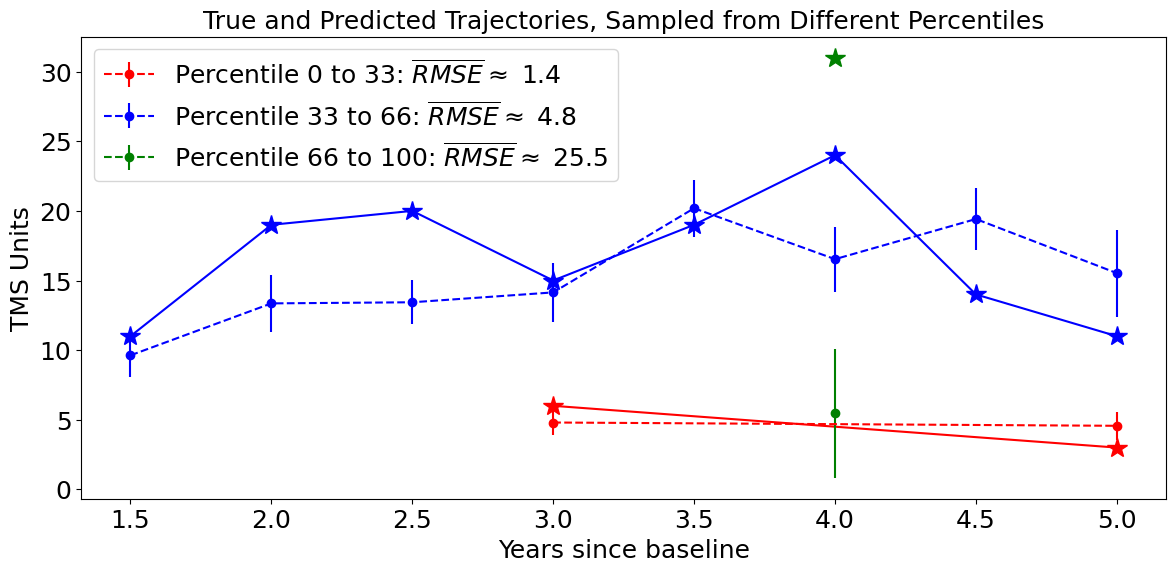

In [ ]:
# Plotting true and predicted sequences

sorted_by_avg_sqdev = sorted(patient_level_results.items(), key=lambda k_v:k_v[1]['avg_sqdev'])

n_subjects = len(sorted_by_avg_sqdev)

idx_0_33 = np.random.randint(0, int(n_subjects / 3))
idx_33_66 = np.random.randint(int(n_subjects / 3), 2 * int(n_subjects / 3))
idx_66_100 = np.random.randint(2 * int(n_subjects / 3), n_subjects)

idx_all = np.array([idx_0_33, idx_33_66, idx_66_100])
labels = np.array(["Percentile 0 to 33", "Percentile 33 to 66", "Percentile 66 to 100"])

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(14)
colors = ["red", "blue", "green"]

for i, idx, label in zip(np.arange(3), idx_all, labels):
  cur_dict = sorted_by_avg_sqdev[idx][1]
  cur_target_times = cur_dict['target_times']
  cur_target_TMS = cur_dict['target_TMS']
  cur_pred_TMS = cur_dict['pred_TMS']
  cur_pred_sigma = cur_dict['pred_sigma']
  cur_avg_sqdev = cur_dict['avg_sqdev']
  ax.plot(cur_target_times, cur_target_TMS, marker = '*', color = colors[i], markersize = 15)
  ax.errorbar(cur_target_times, cur_pred_TMS, yerr = cur_pred_sigma, linestyle = '--', marker = 'o',  color = colors[i], label = label + r': $\overline{RMSE} \approx$ ' + str(np.round(np.sqrt(cur_avg_sqdev), 1)))

ax.set_xlabel("Years since baseline", fontsize = 18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylabel("TMS Units", fontsize = 18)
ax.set_title("True and Predicted Trajectories, Sampled from Different Percentiles", fontsize = 18)
ax.legend( fontsize = 18)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


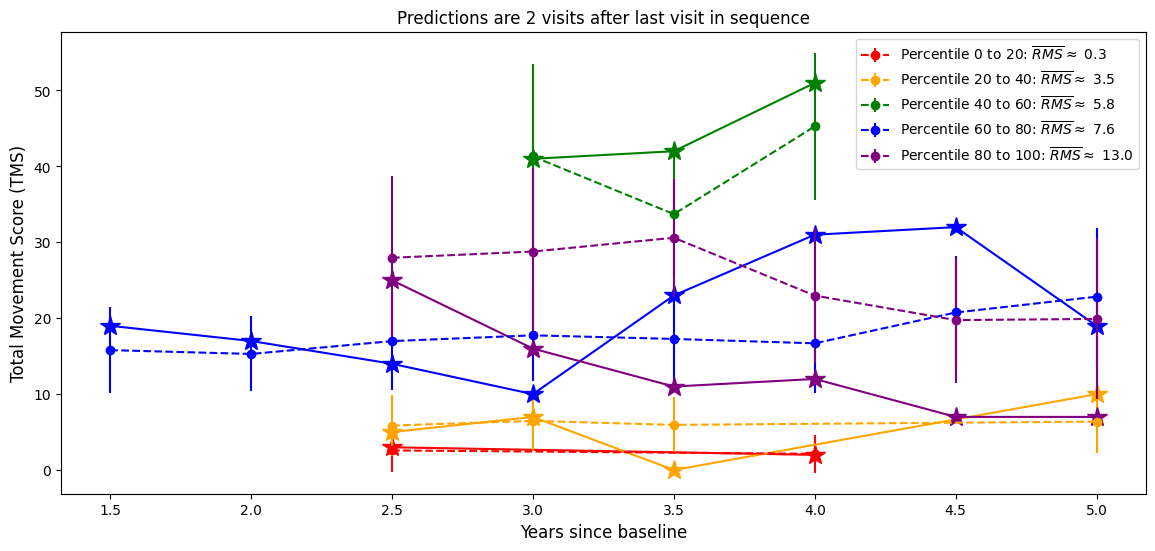

In [ ]:
# Extended prediction to 2nd visit after sequence: plotting true and predicted sequences

sorted_by_avg_sqdev = sorted(ext_2_patient_level_results.items(), key=lambda k_v:k_v[1]['avg_sqdev'])

n_subjects = len(sorted_by_avg_sqdev)

idx_0_20 = np.random.randint(0, int(n_subjects / 5))
idx_20_40 = np.random.randint(int(n_subjects / 5), 2 * int(n_subjects / 5))
idx_40_60 = np.random.randint(2 * int(n_subjects / 5), 3 * int(n_subjects / 5))
idx_60_80 = np.random.randint(3 * int(n_subjects / 5), 4 * int(n_subjects / 5))
idx_80_100 = np.random.randint(4 * int(n_subjects / 5), n_subjects)

idx_all = np.array([idx_0_20, idx_20_40, idx_40_60, idx_60_80, idx_80_100])
labels = np.array(["Percentile 0 to 20", "Percentile 20 to 40", "Percentile 40 to 60", "Percentile 60 to 80", "Percentile 80 to 100"])

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(14)
colors = ["red", "orange", "green", "blue", "purple"]

for i, idx, label in zip(np.arange(5), idx_all, labels):
  cur_dict = sorted_by_avg_sqdev[idx][1]
  cur_target_times = cur_dict['target_times']
  cur_target_TMS = cur_dict['target_TMS']
  cur_pred_TMS = cur_dict['pred_TMS']
  cur_pred_sigma = cur_dict['pred_sigma']
  cur_avg_sqdev = cur_dict['avg_sqdev']
  ax.plot(cur_target_times, cur_target_TMS, marker = '*', color = colors[i], markersize = 15)
  ax.errorbar(cur_target_times, cur_pred_TMS, yerr = cur_pred_sigma, linestyle = '--', marker = 'o',  color = colors[i], label = label + r': $\overline{RMS} \approx$ ' + str(np.round(np.sqrt(cur_avg_sqdev), 1)))

ax.set_xlabel("Years since baseline", fontsize = 12)
ax.set_ylabel("Total Movement Score (TMS)", fontsize = 12)
ax.set_title("Predictions are 2 visits after last visit in sequence")
ax.legend(bbox_to_anchor=(1, 1))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


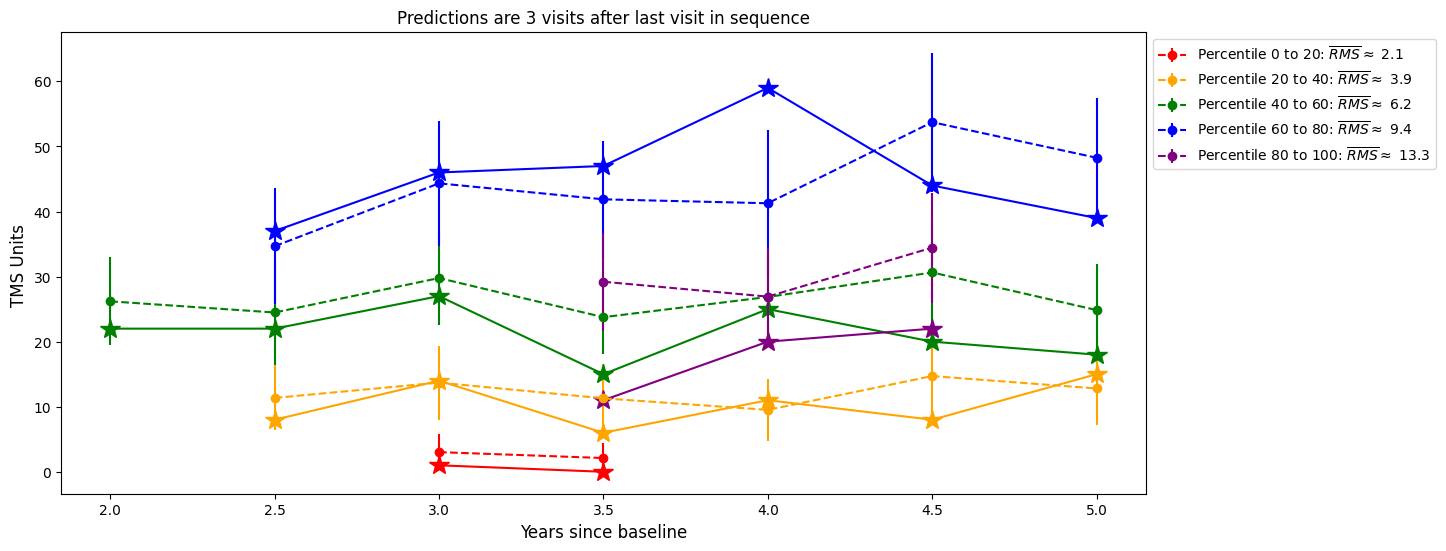

In [ ]:
# Extended prediction to 3rd visit after sequence: plotting true and predicted sequences

sorted_by_avg_sqdev = sorted(ext_3_patient_level_results.items(), key=lambda k_v:k_v[1]['avg_sqdev'])

n_subjects = len(sorted_by_avg_sqdev)

idx_0_20 = np.random.randint(0, int(n_subjects / 5))
idx_20_40 = np.random.randint(int(n_subjects / 5), 2 * int(n_subjects / 5))
idx_40_60 = np.random.randint(2 * int(n_subjects / 5), 3 * int(n_subjects / 5))
idx_60_80 = np.random.randint(3 * int(n_subjects / 5), 4 * int(n_subjects / 5))
idx_80_100 = np.random.randint(4 * int(n_subjects / 5), n_subjects)

idx_all = np.array([idx_0_20, idx_20_40, idx_40_60, idx_60_80, idx_80_100])
labels = np.array(["Percentile 0 to 20", "Percentile 20 to 40", "Percentile 40 to 60", "Percentile 60 to 80", "Percentile 80 to 100"])

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(14)
colors = ["red", "orange", "green", "blue", "purple"]

for i, idx, label in zip(np.arange(5), idx_all, labels):
  cur_dict = sorted_by_avg_sqdev[idx][1]
  cur_target_times = cur_dict['target_times']
  cur_target_TMS = cur_dict['target_TMS']
  cur_pred_TMS = cur_dict['pred_TMS']
  cur_pred_sigma = cur_dict['pred_sigma']
  cur_avg_sqdev = cur_dict['avg_sqdev']
  ax.plot(cur_target_times, cur_target_TMS, marker = '*', color = colors[i], markersize = 15)
  ax.errorbar(cur_target_times, cur_pred_TMS, yerr = cur_pred_sigma, linestyle = '--', marker = 'o',  color = colors[i], label = label + r': $\overline{RMS} \approx$ ' + str(np.round(np.sqrt(cur_avg_sqdev), 1)))

ax.set_xlabel("Years since baseline", fontsize = 12)
ax.set_ylabel("TMS Units", fontsize = 12)
ax.set_title("Predictions are 3 visits after last visit in sequence")
ax.legend(bbox_to_anchor=(1, 1))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


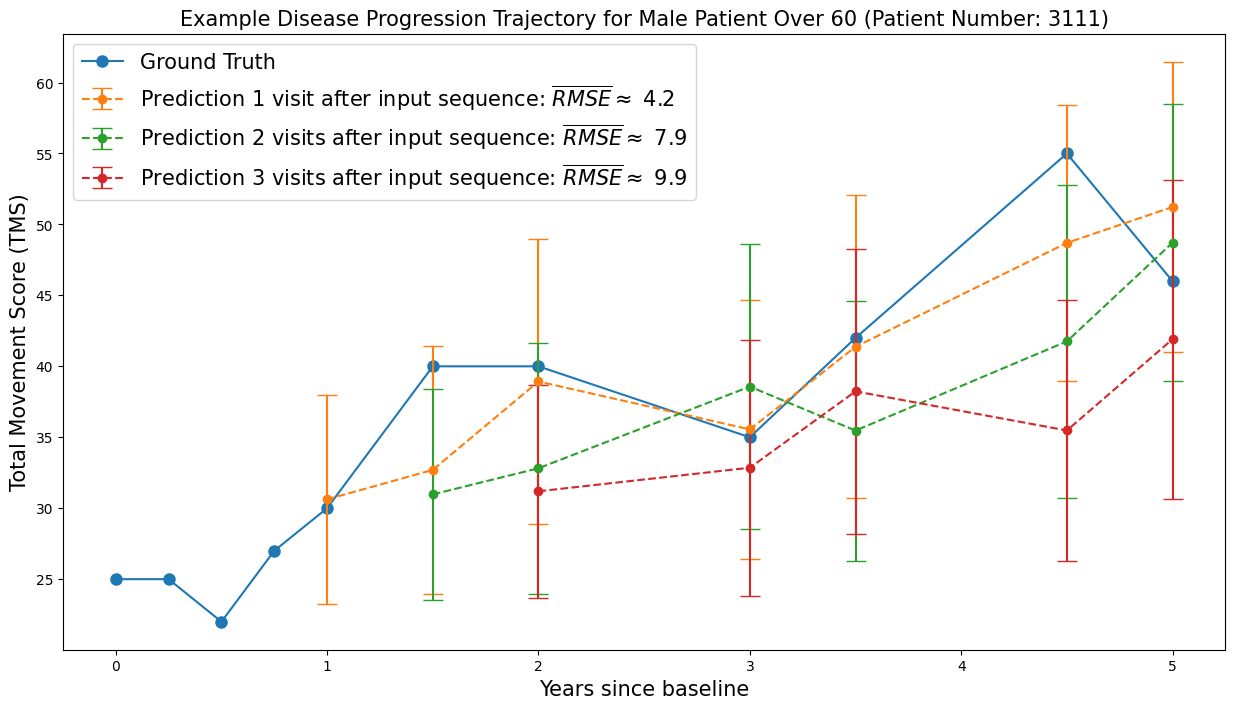

In [ ]:
# Want to look at trajectory plots for different prediction times (1 visit, 2 visits, 3 visits in future) for the SAME patient history

from random import sample

age = np.empty(0)
sex = np.empty(0)

male_a_list_1 = []
male_u_list_1 = []
female_a_list_1 = []
female_u_list_1 = []

for k in patient_level_results:
  pat_sex = patient_level_results[k]['sex']
  pat_age = patient_level_results[k]['age']
  if pat_sex == 1. and pat_age < 60:
    male_u_list_1.append(k)
  elif pat_sex == 1. and pat_age >= 60:
    male_a_list_1.append(k)
  elif pat_sex == 0 and pat_age < 60:
    female_u_list_1.append(k)
  else:
    female_a_list_1.append(k)

male_a_list_2 = []
male_u_list_2 = []
female_a_list_2 = []
female_u_list_2 = []

for k in ext_2_patient_level_results:
  pat_sex = ext_2_patient_level_results[k]['sex']
  pat_age = ext_2_patient_level_results[k]['age']
  if pat_sex == 1. and pat_age < 60:
    male_u_list_2.append(k)
  elif pat_sex == 1. and pat_age >= 60:
    male_a_list_2.append(k)
  elif pat_sex == 0 and pat_age < 60:
    female_u_list_2.append(k)
  else:
    female_a_list_2.append(k)

male_a_list_3 = []
male_u_list_3 = []
female_a_list_3 = []
female_u_list_3 = []

for k in ext_3_patient_level_results:
  pat_sex = ext_3_patient_level_results[k]['sex']
  pat_age = ext_3_patient_level_results[k]['age']
  if pat_sex == 1. and pat_age < 60:
    male_u_list_3.append(k)
  elif pat_sex == 1. and pat_age >= 60:
    male_a_list_3.append(k)
  elif pat_sex == 0 and pat_age < 60:
    female_u_list_3.append(k)
  else:
    female_a_list_3.append(k)

# Find the intersection of all the patients in each prediction time case
male_a_intersect = list(set(male_a_list_1) & set(male_a_list_2) & set(male_a_list_3))
male_u_intersect = list(set(male_u_list_1) & set(male_u_list_2) & set(male_u_list_3))
female_a_intersect = list(set(female_a_list_1) & set(female_a_list_2) & set(female_a_list_3))
female_u_intersect = list(set(female_u_list_1) & set(female_u_list_2) & set(female_u_list_3))

# Sample one patient from the intersection
male_a_sample_patno = sample(male_a_intersect, 1)[0]
male_u_sample_patno = sample(male_u_intersect, 1)[0]
female_a_sample_patno = sample(female_a_intersect, 1)[0]
female_u_sample_patno = sample(female_u_intersect, 1)[0]


# Male above 60
male_a_dict_1 = patient_level_results[male_a_sample_patno]
male_a_dict_2 = ext_2_patient_level_results[male_a_sample_patno]
male_a_dict_3 = ext_3_patient_level_results[male_a_sample_patno]
male_a_target_times_1 = male_a_dict_1['target_times']
male_a_target_TMS_1 = male_a_dict_1['target_TMS']
male_a_pred_TMS_1 = male_a_dict_1['pred_TMS']
male_a_pred_sigma_1 = male_a_dict_1['pred_sigma']
male_a_avg_sqdev_1 = male_a_dict_1['avg_sqdev']

male_a_ground_truth_times = male_a_dict_1['seq_times'][0] + male_a_target_times_1.tolist()
male_a_ground_truth_tms = male_a_dict_1['seq_tms'][0] + male_a_target_TMS_1.tolist()

# Target times for prediction extended n visits into the future are
# the original target times without the first n elemenets

male_a_target_times_2 = male_a_target_times_1[1:]
male_a_pred_TMS_2 = male_a_dict_2['pred_TMS']
male_a_pred_sigma_2 = male_a_dict_2['pred_sigma']
male_a_avg_sqdev_2 = male_a_dict_2['avg_sqdev']

male_a_target_times_3 = male_a_target_times_1[2:]
male_a_pred_TMS_3 = male_a_dict_3['pred_TMS']
male_a_pred_sigma_3 = male_a_dict_3['pred_sigma']
male_a_avg_sqdev_3 = male_a_dict_3['avg_sqdev']


# Male under 60
male_u_dict_1 = patient_level_results[male_u_sample_patno]
male_u_dict_2 = ext_2_patient_level_results[male_u_sample_patno]
male_u_dict_3 = ext_3_patient_level_results[male_u_sample_patno]
male_u_target_times_1 = male_u_dict_1['target_times']
male_u_target_TMS_1 = male_u_dict_1['target_TMS']
male_u_pred_TMS_1 = male_u_dict_1['pred_TMS']
male_u_pred_sigma_1 = male_u_dict_1['pred_sigma']
male_u_avg_sqdev_1 = male_u_dict_1['avg_sqdev']

male_u_ground_truth_times = male_u_dict_1['seq_times'][0] + male_u_target_times_1.tolist()
male_u_ground_truth_tms = male_u_dict_1['seq_tms'][0] + male_u_target_TMS_1.tolist()

# Target times for prediction extended n visits into the future are
# the original target times without the first n elemenets

male_u_target_times_2 = male_u_target_times_1[1:]
male_u_pred_TMS_2 = male_u_dict_2['pred_TMS']
male_u_pred_sigma_2 = male_u_dict_2['pred_sigma']
male_u_avg_sqdev_2 = male_u_dict_2['avg_sqdev']

male_u_target_times_3 = male_u_target_times_1[2:]
male_u_pred_TMS_3 = male_u_dict_3['pred_TMS']
male_u_pred_sigma_3 = male_u_dict_3['pred_sigma']
male_u_avg_sqdev_3 = male_u_dict_3['avg_sqdev']


# Female above 60
female_a_dict_1 = patient_level_results[female_a_sample_patno]
female_a_dict_2 = ext_2_patient_level_results[female_a_sample_patno]
female_a_dict_3 = ext_3_patient_level_results[female_a_sample_patno]
female_a_target_times_1 = female_a_dict_1['target_times']
female_a_target_TMS_1 = female_a_dict_1['target_TMS']
female_a_pred_TMS_1 = female_a_dict_1['pred_TMS']
female_a_pred_sigma_1 = female_a_dict_1['pred_sigma']
female_a_avg_sqdev_1 = female_a_dict_1['avg_sqdev']

female_a_ground_truth_times = female_a_dict_1['seq_times'][0] + female_a_target_times_1.tolist()
female_a_ground_truth_tms = female_a_dict_1['seq_tms'][0] + female_a_target_TMS_1.tolist()

# Target times for prediction extended n visits into the future are
# the original target times without the first n elemenets

female_a_target_times_2 = female_a_target_times_1[1:]
female_a_pred_TMS_2 = female_a_dict_2['pred_TMS']
female_a_pred_sigma_2 = female_a_dict_2['pred_sigma']
female_a_avg_sqdev_2 = female_a_dict_2['avg_sqdev']

female_a_target_times_3 = female_a_target_times_1[2:]
female_a_pred_TMS_3 = female_a_dict_3['pred_TMS']
female_a_pred_sigma_3 = female_a_dict_3['pred_sigma']
female_a_avg_sqdev_3 = female_a_dict_3['avg_sqdev']


# Female under 60
female_u_dict_1 = patient_level_results[female_u_sample_patno]
female_u_dict_2 = ext_2_patient_level_results[female_u_sample_patno]
female_u_dict_3 = ext_3_patient_level_results[female_u_sample_patno]
female_u_target_times_1 = female_u_dict_1['target_times']
female_u_target_TMS_1 = female_u_dict_1['target_TMS']
female_u_pred_TMS_1 = female_u_dict_1['pred_TMS']
female_u_pred_sigma_1 = female_u_dict_1['pred_sigma']
female_u_avg_sqdev_1 = female_u_dict_1['avg_sqdev']

female_u_ground_truth_times = female_u_dict_1['seq_times'][0] + female_u_target_times_1.tolist()
female_u_ground_truth_tms = female_u_dict_1['seq_tms'][0] + female_u_target_TMS_1.tolist()

# Target times for prediction extended n visits into the future are
# the original target times without the first n elemenets

female_u_target_times_2 = female_u_target_times_1[1:]
female_u_pred_TMS_2 = female_u_dict_2['pred_TMS']
female_u_pred_sigma_2 = female_u_dict_2['pred_sigma']
female_u_avg_sqdev_2 = female_u_dict_2['avg_sqdev']

female_u_target_times_3 = female_u_target_times_1[2:]
female_u_pred_TMS_3 = female_u_dict_3['pred_TMS']
female_u_pred_sigma_3 = female_u_dict_3['pred_sigma']
female_u_avg_sqdev_3 = female_u_dict_3['avg_sqdev']



# Plotting
fig1, ax1 = plt.subplots()
fig1.set_figheight(8)
fig1.set_figwidth(15)
ax1.plot(male_a_ground_truth_times, male_a_ground_truth_tms, marker = 'o', markersize = 8, label = 'Ground Truth')
ax1.errorbar(male_a_target_times_1, male_a_pred_TMS_1, yerr = male_a_pred_sigma_1, linestyle = '--', marker = 'o', label = 'Prediction 1 visit after input sequence' + r': $\overline{RMSE} \approx$ ' + str(np.round(np.sqrt(male_a_avg_sqdev_1), 1)), capsize = 7)
ax1.errorbar(male_a_target_times_2, male_a_pred_TMS_2, yerr = male_a_pred_sigma_2, linestyle = '--', marker = 'o', label = 'Prediction 2 visits after input sequence' + r': $\overline{RMSE} \approx$ ' + str(np.round(np.sqrt(male_a_avg_sqdev_2), 1)), capsize = 7)
ax1.errorbar(male_a_target_times_3, male_a_pred_TMS_3, yerr = male_a_pred_sigma_3, linestyle = '--', marker = 'o', label = 'Prediction 3 visits after input sequence' + r': $\overline{RMSE} \approx$ ' + str(np.round(np.sqrt(male_a_avg_sqdev_3), 1)), capsize = 7)
ax1.set_xlabel("Years since baseline", fontsize = 15)
ax1.set_ylabel("Total Movement Score (TMS)", fontsize = 15)
ax1.set_title(f"Example Disease Progression Trajectory for Male Patient Over 60 (Patient Number: {int(male_a_sample_patno)})", fontsize = 15)
ax1.legend(fontsize = 15)

#fig2, ax2 = plt.subplots()
#fig2.set_figheight(8)
#fig2.set_figwidth(15)
#ax2.plot(male_u_ground_truth_times, male_u_ground_truth_tms, marker = 'o', markersize = 8, label = 'Ground Truth')
#ax2.errorbar(male_u_target_times_1, male_u_pred_TMS_1, yerr = male_u_pred_sigma_1, linestyle = '--', marker = 'o', label = 'Prediction 1 visit after input sequence' + r': $\overline{RMS} \approx$ ' + str(np.round(np.sqrt(male_u_avg_sqdev_1), 1)), capsize = 7)
#ax2.errorbar(male_u_target_times_2, male_u_pred_TMS_2, yerr = male_u_pred_sigma_2, linestyle = '--', marker = 'o', label = 'Prediction 2 visits after input sequence' + r': $\overline{RMS} \approx$ ' + str(np.round(np.sqrt(male_u_avg_sqdev_2), 1)), capsize = 7)
#ax2.errorbar(male_u_target_times_3, male_u_pred_TMS_3, yerr = male_u_pred_sigma_3, linestyle = '--', marker = 'o', label = 'Prediction 3 visits after input sequence' + r': $\overline{RMS} \approx$ ' + str(np.round(np.sqrt(male_u_avg_sqdev_3), 1)), capsize = 7)
#ax2.set_xlabel("Years since baseline", fontsize = 12)
#ax2.set_ylabel("Total Movement Score (TMS)", fontsize = 12)
#ax2.set_title(f"Example Disease Progression Trajectory for Male Patient Under 60 (Patient Number: {int(male_u_sample_patno)})")
#ax2.legend()

#fig3, ax3 = plt.subplots()
#fig3.set_figheight(8)
#fig3.set_figwidth(15)
#ax3.plot(female_a_ground_truth_times, female_a_ground_truth_tms, marker = 'o', markersize = 8, label = 'Ground Truth')
#ax3.errorbar(female_a_target_times_1, female_a_pred_TMS_1, yerr = female_a_pred_sigma_1, linestyle = '--', marker = 'o', label = 'Prediction 1 visit after input sequence' + r': $\overline{RMS} \approx$ ' + str(np.round(np.sqrt(female_a_avg_sqdev_1), 1)), capsize = 7)
#ax3.errorbar(female_a_target_times_2, female_a_pred_TMS_2, yerr = female_a_pred_sigma_2, linestyle = '--', marker = 'o', label = 'Prediction 2 visits after input sequence' + r': $\overline{RMS} \approx$ ' + str(np.round(np.sqrt(female_a_avg_sqdev_2), 1)), capsize = 7)
#ax3.errorbar(female_a_target_times_3, female_a_pred_TMS_3, yerr = female_a_pred_sigma_3, linestyle = '--', marker = 'o', label = 'Prediction 3 visits after input sequence' + r': $\overline{RMS} \approx$ ' + str(np.round(np.sqrt(female_a_avg_sqdev_3), 1)), capsize = 7)
#ax3.set_xlabel("Years since baseline", fontsize = 12)
#ax3.set_ylabel("Total Movement Score (TMS)", fontsize = 12)
#ax3.set_title(f"Example Disease Progression Trajectory for Female Patient Over 60 (Patient Number: {int(female_a_sample_patno)})")
#ax3.legend()

#fig4, ax4 = plt.subplots()
#fig4.set_figheight(8)
#fig4.set_figwidth(15)
#ax4.plot(female_u_ground_truth_times, female_u_ground_truth_tms, marker = 'o', markersize = 8, label = 'Ground Truth')
#ax4.errorbar(female_u_target_times_1, female_u_pred_TMS_1, yerr = female_u_pred_sigma_1, linestyle = '--', marker = 'o', label = 'Prediction 1 visit after input sequence' + r': $\overline{RMS} \approx$ ' + str(np.round(np.sqrt(female_u_avg_sqdev_1), 1)), capsize = 7)
#ax4.errorbar(female_u_target_times_2, female_u_pred_TMS_2, yerr = female_u_pred_sigma_2, linestyle = '--', marker = 'o', label = 'Prediction 2 visits after input sequence' + r': $\overline{RMS} \approx$ ' + str(np.round(np.sqrt(female_u_avg_sqdev_2), 1)), capsize = 7)
#ax4.errorbar(female_u_target_times_3, female_u_pred_TMS_3, yerr = female_u_pred_sigma_3, linestyle = '--', marker = 'o', label = 'Prediction 3 visits after input sequence' + r': $\overline{RMS} \approx$ ' + str(np.round(np.sqrt(female_u_avg_sqdev_3), 1)), capsize = 7)
#ax4.set_xlabel("Years since baseline", fontsize = 12)
#ax4.set_ylabel("Total Movement Score (TMS)", fontsize = 12)
#ax4.set_title(f"Example Disease Progression Trajectory for Female Patient Under 60 (Patient Number: {int(female_u_sample_patno)})")
#ax4.legend()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(54, 1.5, 'Ratio of medians: 0.26')

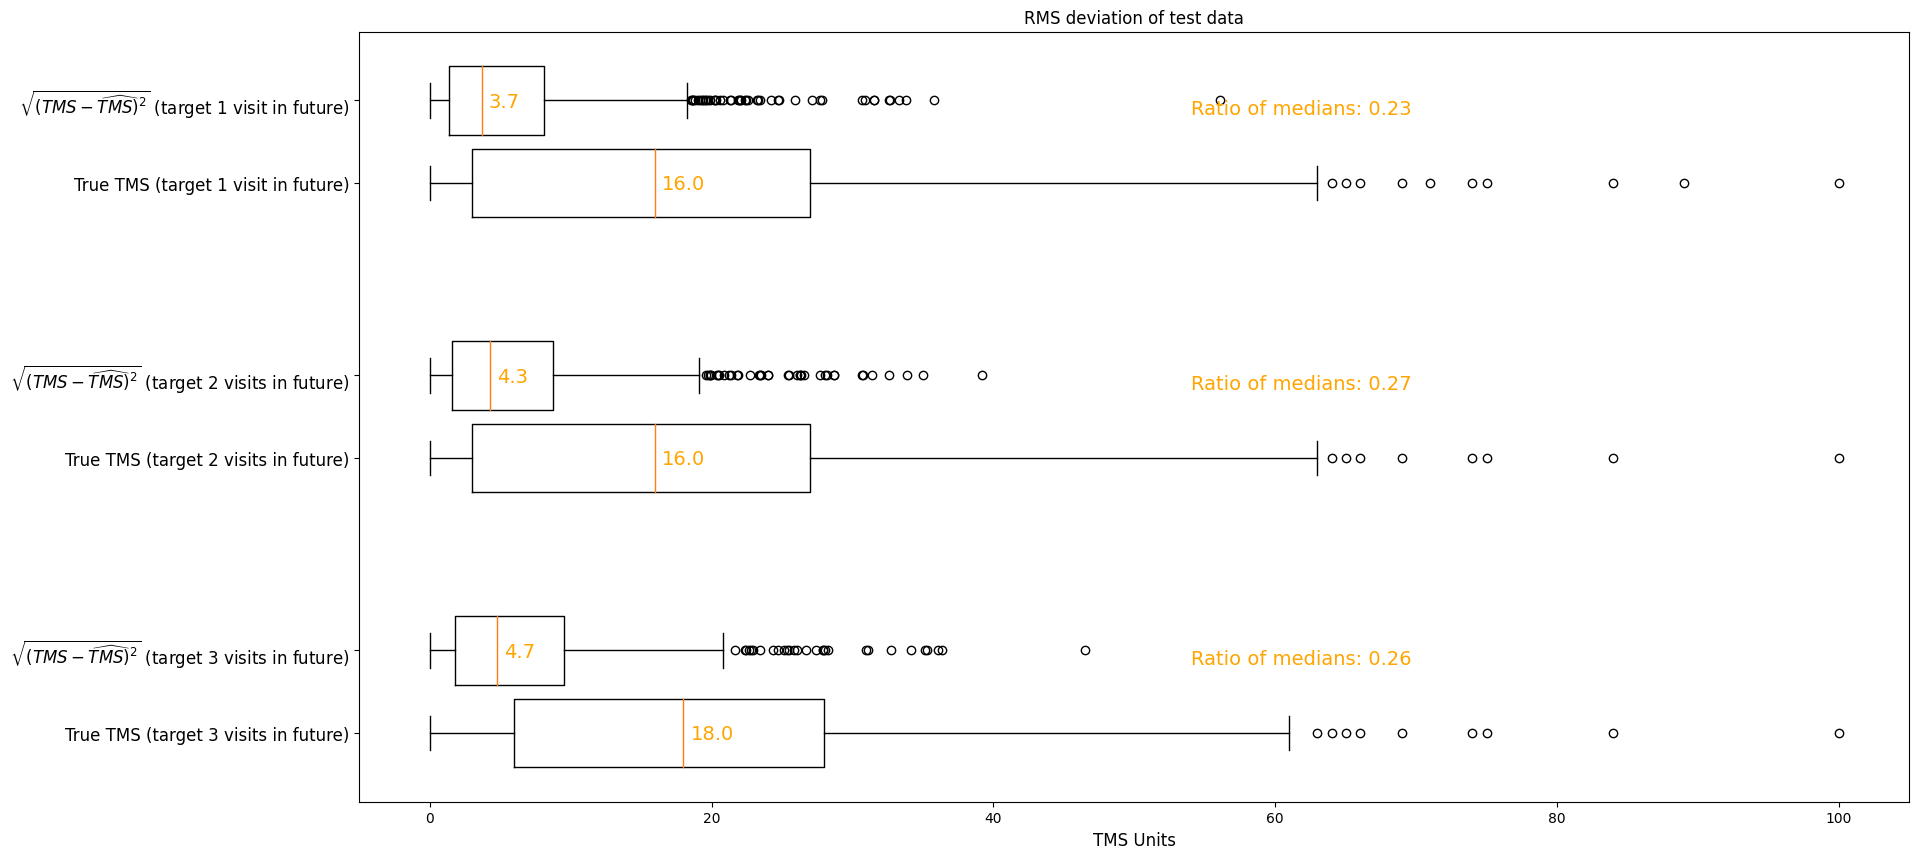

In [ ]:
rms = np.empty(0)
tms = np.empty(0)
ext_2_rms = np.empty(0)
ext_2_tms = np.empty(0)
ext_3_rms = np.empty(0)
ext_3_tms = np.empty(0)

for k in patient_level_results:
  rms = np.concatenate((rms, np.sqrt(patient_level_results[k]["sqdev"])))
  tms = np.concatenate((tms, patient_level_results[k]["all_tms"]))

for k in ext_2_patient_level_results:
  ext_2_rms = np.concatenate((ext_2_rms, np.sqrt(ext_2_patient_level_results[k]["sqdev"])))
  ext_2_tms = np.concatenate((ext_2_tms, ext_2_patient_level_results[k]["all_tms"]))

for k in ext_3_patient_level_results:
  ext_3_rms = np.concatenate((ext_3_rms, np.sqrt(ext_3_patient_level_results[k]["sqdev"])))
  ext_3_tms = np.concatenate((ext_3_tms, ext_3_patient_level_results[k]["all_tms"]))

rms_tms_dict = {"True TMS (target 3 visits in future)":ext_3_tms,
                r"$\sqrt{(TMS - \widehat{TMS})^2}$ (target 3 visits in future)":ext_3_rms,
                "True TMS (target 2 visits in future)":ext_2_tms,
                r"$\sqrt{(TMS - \widehat{TMS})^2}$ (target 2 visits in future)":ext_2_rms,
                "True TMS (target 1 visit in future)":tms,
                r"$\sqrt{(TMS - \widehat{TMS})^2}$ (target 1 visit in future)":rms}


fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
ax.boxplot(rms_tms_dict.values(), vert = False, positions = [1, 1.6, 3, 3.6, 5, 5.6]);
ax.set_xlabel("TMS Units", size = 12);
ax.set_yticklabels(rms_tms_dict.keys(), fontsize = 12);
ax.set_title("RMS deviation of test data", size = 12);
ax.text(boxplot_stats(rms)[0]['med'] + 0.5, 5.55, round(boxplot_stats(rms)[0]['med'], 1), color = 'orange', fontsize = 14)
ax.text(boxplot_stats(tms)[0]['med'] + 0.5, 4.95, round(boxplot_stats(tms)[0]['med'], 1), color = 'orange', fontsize = 14)
ax.text(54, 5.5, f"Ratio of medians: {round(boxplot_stats(rms)[0]['med'] / boxplot_stats(tms)[0]['med'], 2)}", color = 'orange', fontsize = 14)
ax.text(boxplot_stats(ext_2_rms)[0]['med'] + 0.5, 3.55, round(boxplot_stats(ext_2_rms)[0]['med'], 1), color = 'orange', fontsize = 14)
ax.text(boxplot_stats(ext_2_tms)[0]['med'] + 0.5, 2.95, round(boxplot_stats(ext_2_tms)[0]['med'], 1), color = 'orange', fontsize = 14)
ax.text(54, 3.5, f"Ratio of medians: {round(boxplot_stats(ext_2_rms)[0]['med'] / boxplot_stats(ext_2_tms)[0]['med'], 2)}", color = 'orange', fontsize = 14)
ax.text(boxplot_stats(ext_3_rms)[0]['med'] + 0.5, 1.55, round(boxplot_stats(ext_3_rms)[0]['med'], 1), color = 'orange', fontsize = 14)
ax.text(boxplot_stats(ext_3_tms)[0]['med'] + 0.5, 0.95, round(boxplot_stats(ext_3_tms)[0]['med'], 1), color = 'orange', fontsize = 14)
ax.text(54, 1.5, f"Ratio of medians: {round(boxplot_stats(ext_3_rms)[0]['med'] / boxplot_stats(ext_3_tms)[0]['med'], 2)}", color = 'orange', fontsize = 14)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


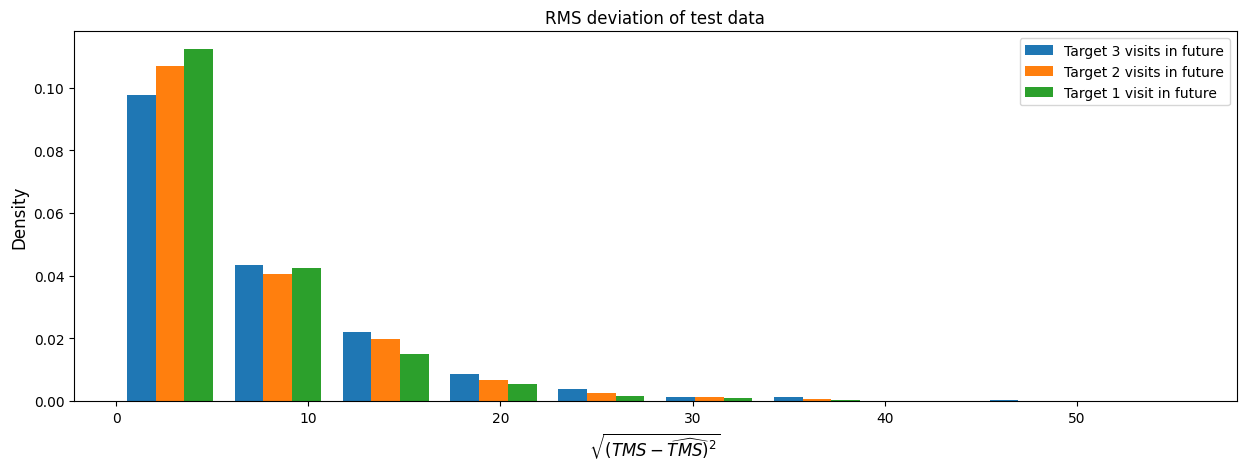

In [ ]:
rms_dict = {"Target 3 visits in future":ext_3_rms,
            "Target 2 visits in future":ext_2_rms,
            "Target 1 visit in future":rms}

fig, ax2 = plt.subplots()
fig.set_figwidth(15)
ax2.hist(rms_dict.values(), density = True, label = list(rms_dict.keys()));
ax2.set_xlabel(r"$\sqrt{(TMS - \widehat{TMS})^2}$", size = 12);
ax2.set_ylabel("Density", size = 12);
ax2.set_title("RMS deviation of test data", size = 12);
ax2.legend()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


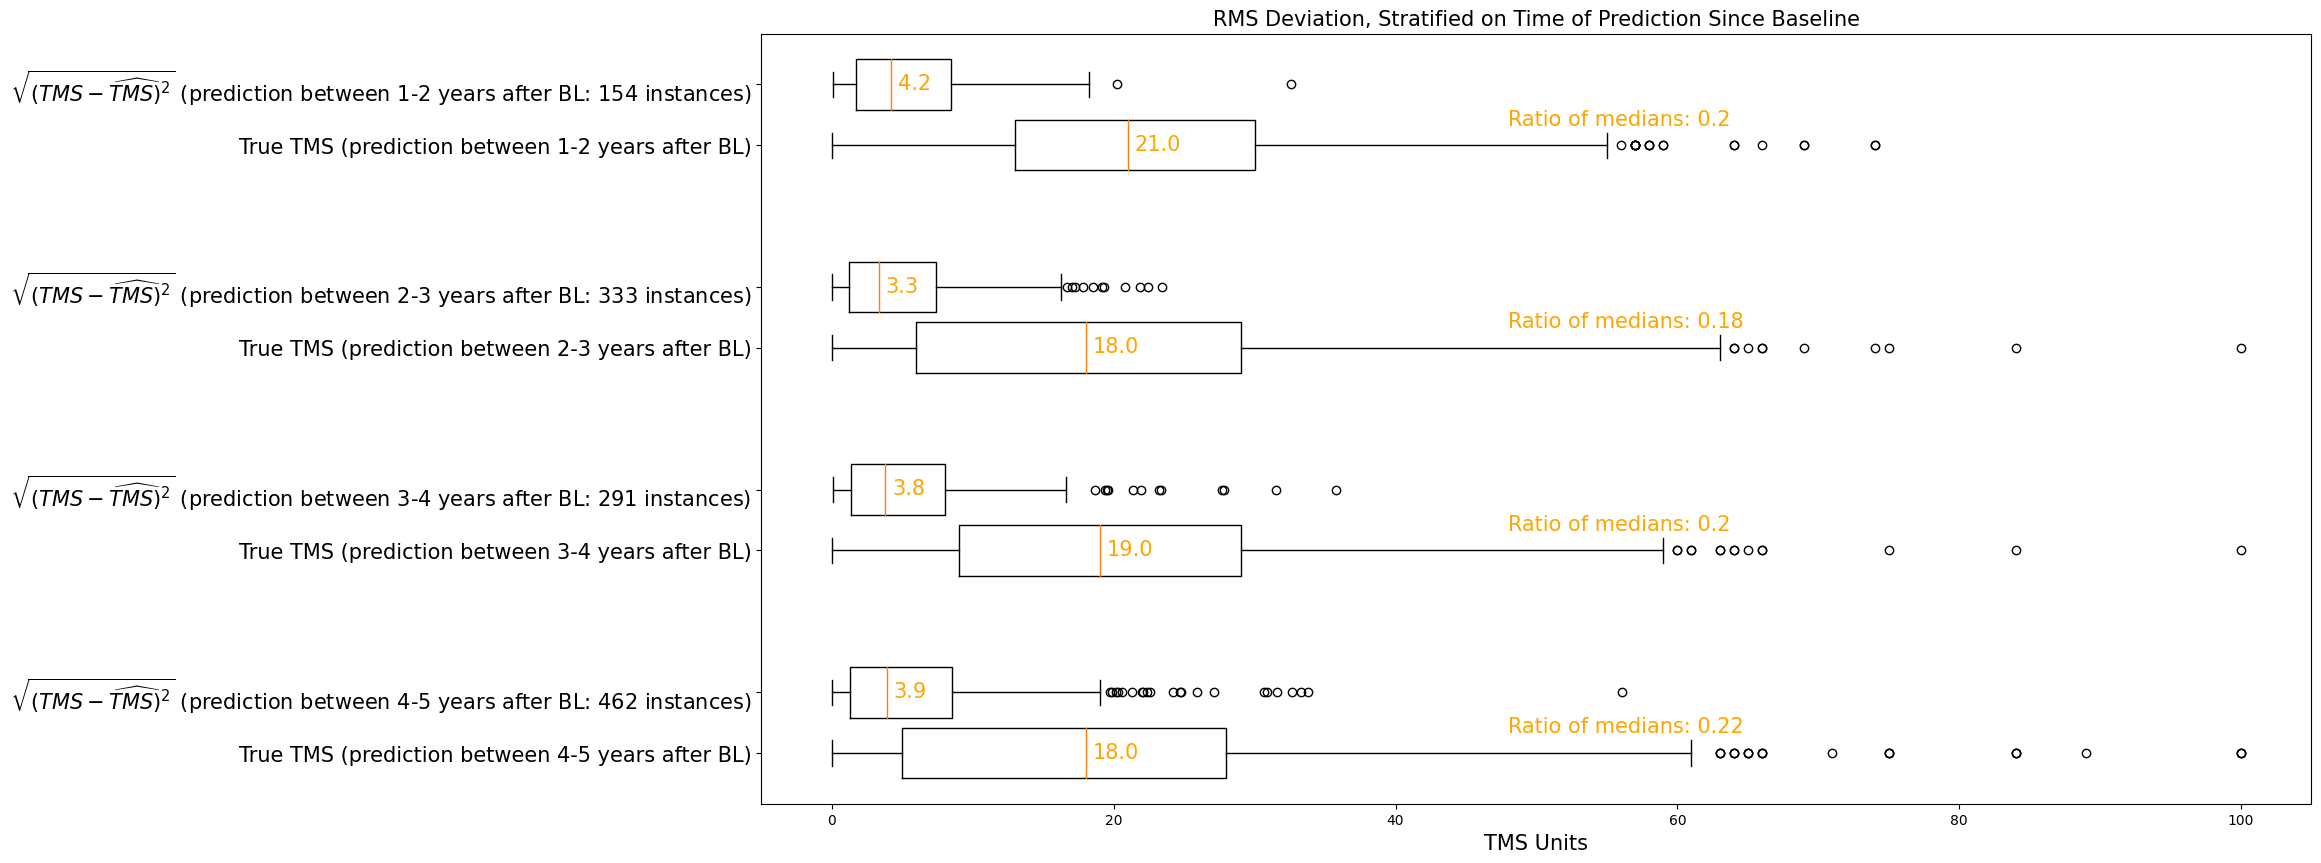

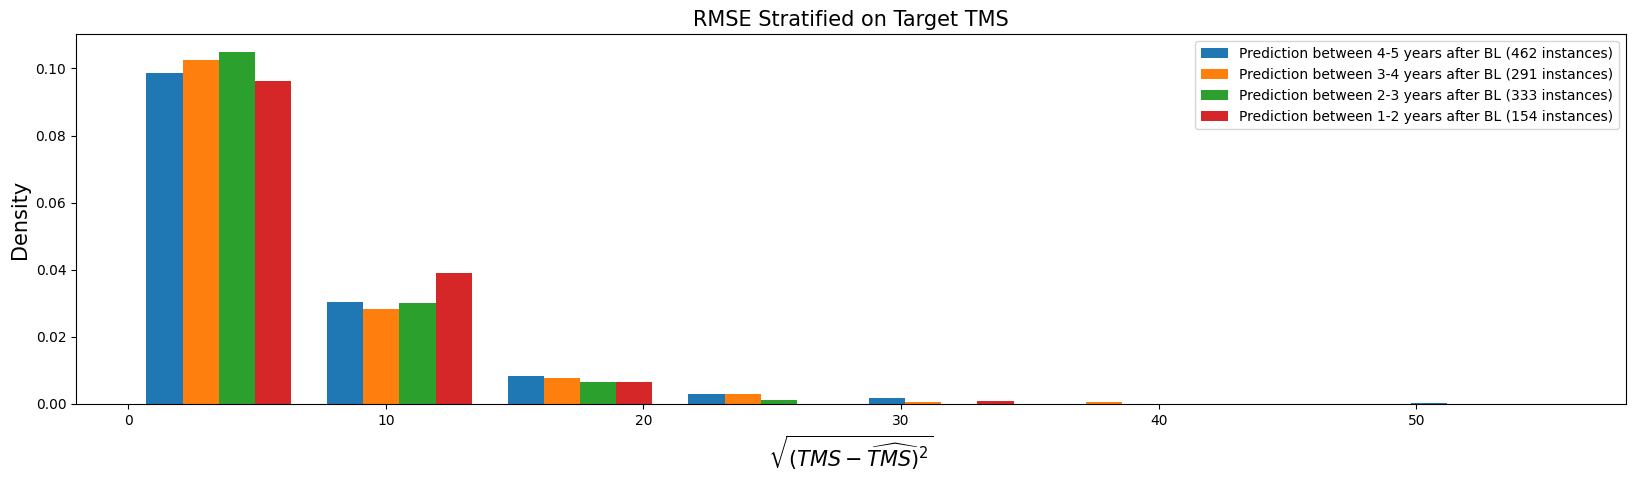

In [ ]:
# Stratifying RMS on time of prediction since baseline

rms_t1_2 = np.empty(0)
rms_t2_3 = np.empty(0)
rms_t3_4 = np.empty(0)
rms_t4_5 = np.empty(0)
tms_t1_2 = np.empty(0)
tms_t2_3 = np.empty(0)
tms_t3_4 = np.empty(0)
tms_t4_5 = np.empty(0)
time_1_2 = np.empty(0)
time_2_3 = np.empty(0)
time_3_4 = np.empty(0)
time_4_5 = np.empty(0)

for key in patient_level_results:
  all_target_times = patient_level_results[key]['target_times']
  all_sqdev = patient_level_results[key]['sqdev']
  for i in range(len(all_target_times)):
    t = all_target_times[i]
    rms = np.sqrt(all_sqdev[i])
    if t >= 1 and t < 2:
      time_1_2 = np.concatenate((time_1_2, [t]))
      rms_t1_2 = np.concatenate((rms_t1_2, [rms]))
      tms_t1_2 = np.concatenate((tms_t1_2, patient_level_results[key]["all_tms"]))
    elif t >= 2 and t < 3:
      time_2_3 = np.concatenate((time_2_3, [t]))
      rms_t2_3 = np.concatenate((rms_t2_3, [rms]))
      tms_t2_3 = np.concatenate((tms_t2_3, patient_level_results[key]["all_tms"]))
    elif t >= 3 and t < 4:
      time_3_4 = np.concatenate((time_3_4, [t]))
      rms_t3_4 = np.concatenate((rms_t3_4, [rms]))
      tms_t3_4 = np.concatenate((tms_t3_4, patient_level_results[key]["all_tms"]))
    elif t >= 4 and t <= 5:
      time_4_5 = np.concatenate((time_4_5, [t]))
      rms_t4_5 = np.concatenate((rms_t4_5, [rms]))
      tms_t4_5 = np.concatenate((tms_t4_5, patient_level_results[key]["all_tms"]))


rms_tms_time_dict = {"True TMS (prediction between 4-5 years after BL)":tms_t4_5,
                 r"$\sqrt{(TMS - \widehat{TMS})^2}$ (prediction between 4-5 years after BL: %i instances)" % len(rms_t4_5):rms_t4_5,
                 "True TMS (prediction between 3-4 years after BL)":tms_t3_4,
                 r"$\sqrt{(TMS - \widehat{TMS})^2}$ (prediction between 3-4 years after BL: %i instances)" % len(rms_t3_4):rms_t3_4,
                 "True TMS (prediction between 2-3 years after BL)":tms_t2_3,
                 r"$\sqrt{(TMS - \widehat{TMS})^2}$ (prediction between 2-3 years after BL: %i instances)" % len(rms_t2_3):rms_t2_3,
                 "True TMS (prediction between 1-2 years after BL)":tms_t1_2,
                 r"$\sqrt{(TMS - \widehat{TMS})^2}$ (prediction between 1-2 years after BL: %i instances)" % len(rms_t1_2):rms_t1_2}

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
ax.boxplot(rms_tms_time_dict.values(), vert = False, positions = [1, 1.6, 3, 3.6, 5, 5.6, 7, 7.6]);
ax.set_xlabel("TMS Units", size = 15);
ax.set_yticklabels(rms_tms_time_dict.keys(), fontsize = 15);
ax.set_title("RMS Deviation, Stratified on Time of Prediction Since Baseline", size = 15);

ax.text(boxplot_stats(rms_t1_2)[0]['med'] + 0.5, 7.55, round(boxplot_stats(rms_t1_2)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(tms_t1_2)[0]['med'] + 0.5, 6.95, round(boxplot_stats(tms_t1_2)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 7.2, f"Ratio of medians: {round(boxplot_stats(rms_t1_2)[0]['med']/boxplot_stats(tms_t1_2)[0]['med'], 2)}", color = 'orange', fontsize = 15)

ax.text(boxplot_stats(rms_t2_3)[0]['med'] + 0.5, 5.55, round(boxplot_stats(rms_t2_3)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(tms_t2_3)[0]['med'] + 0.5, 4.95, round(boxplot_stats(tms_t2_3)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 5.2, f"Ratio of medians: {round(boxplot_stats(rms_t2_3)[0]['med']/boxplot_stats(tms_t2_3)[0]['med'], 2)}", color = 'orange', fontsize = 15)

ax.text(boxplot_stats(rms_t3_4)[0]['med'] + 0.5, 3.55, round(boxplot_stats(rms_t3_4)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(tms_t3_4)[0]['med'] + 0.5, 2.95, round(boxplot_stats(tms_t3_4)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 3.2, f"Ratio of medians: {round(boxplot_stats(rms_t3_4)[0]['med']/boxplot_stats(tms_t3_4)[0]['med'], 2)}", color = 'orange', fontsize = 15)

ax.text(boxplot_stats(rms_t4_5)[0]['med'] + 0.5, 1.55, round(boxplot_stats(rms_t4_5)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(tms_t4_5)[0]['med'] + 0.5, 0.95, round(boxplot_stats(tms_t4_5)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 1.2, f"Ratio of medians: {round(boxplot_stats(rms_t4_5)[0]['med']/boxplot_stats(tms_t4_5)[0]['med'], 2)}", color = 'orange', fontsize = 15)

rms_time_dict = {f"Prediction between 4-5 years after BL ({len(rms_t4_5)} instances)":rms_t4_5,
                 f"Prediction between 3-4 years after BL ({len(rms_t3_4)} instances)":rms_t3_4,
                 f"Prediction between 2-3 years after BL ({len(rms_t2_3)} instances)":rms_t2_3,
                 f"Prediction between 1-2 years after BL ({len(rms_t1_2)} instances)":rms_t1_2}

fig, ax2 = plt.subplots()
fig.set_figwidth(20)
ax2.hist(rms_time_dict.values(), label = list(rms_time_dict.keys()), bins = 8, density = True);
ax2.set_xlabel(r"$\sqrt{(TMS - \widehat{TMS})^2}$", size = 15);
ax2.set_ylabel("Density", size = 15)
ax2.set_title("RMSE", size = 15);
ax2.legend();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


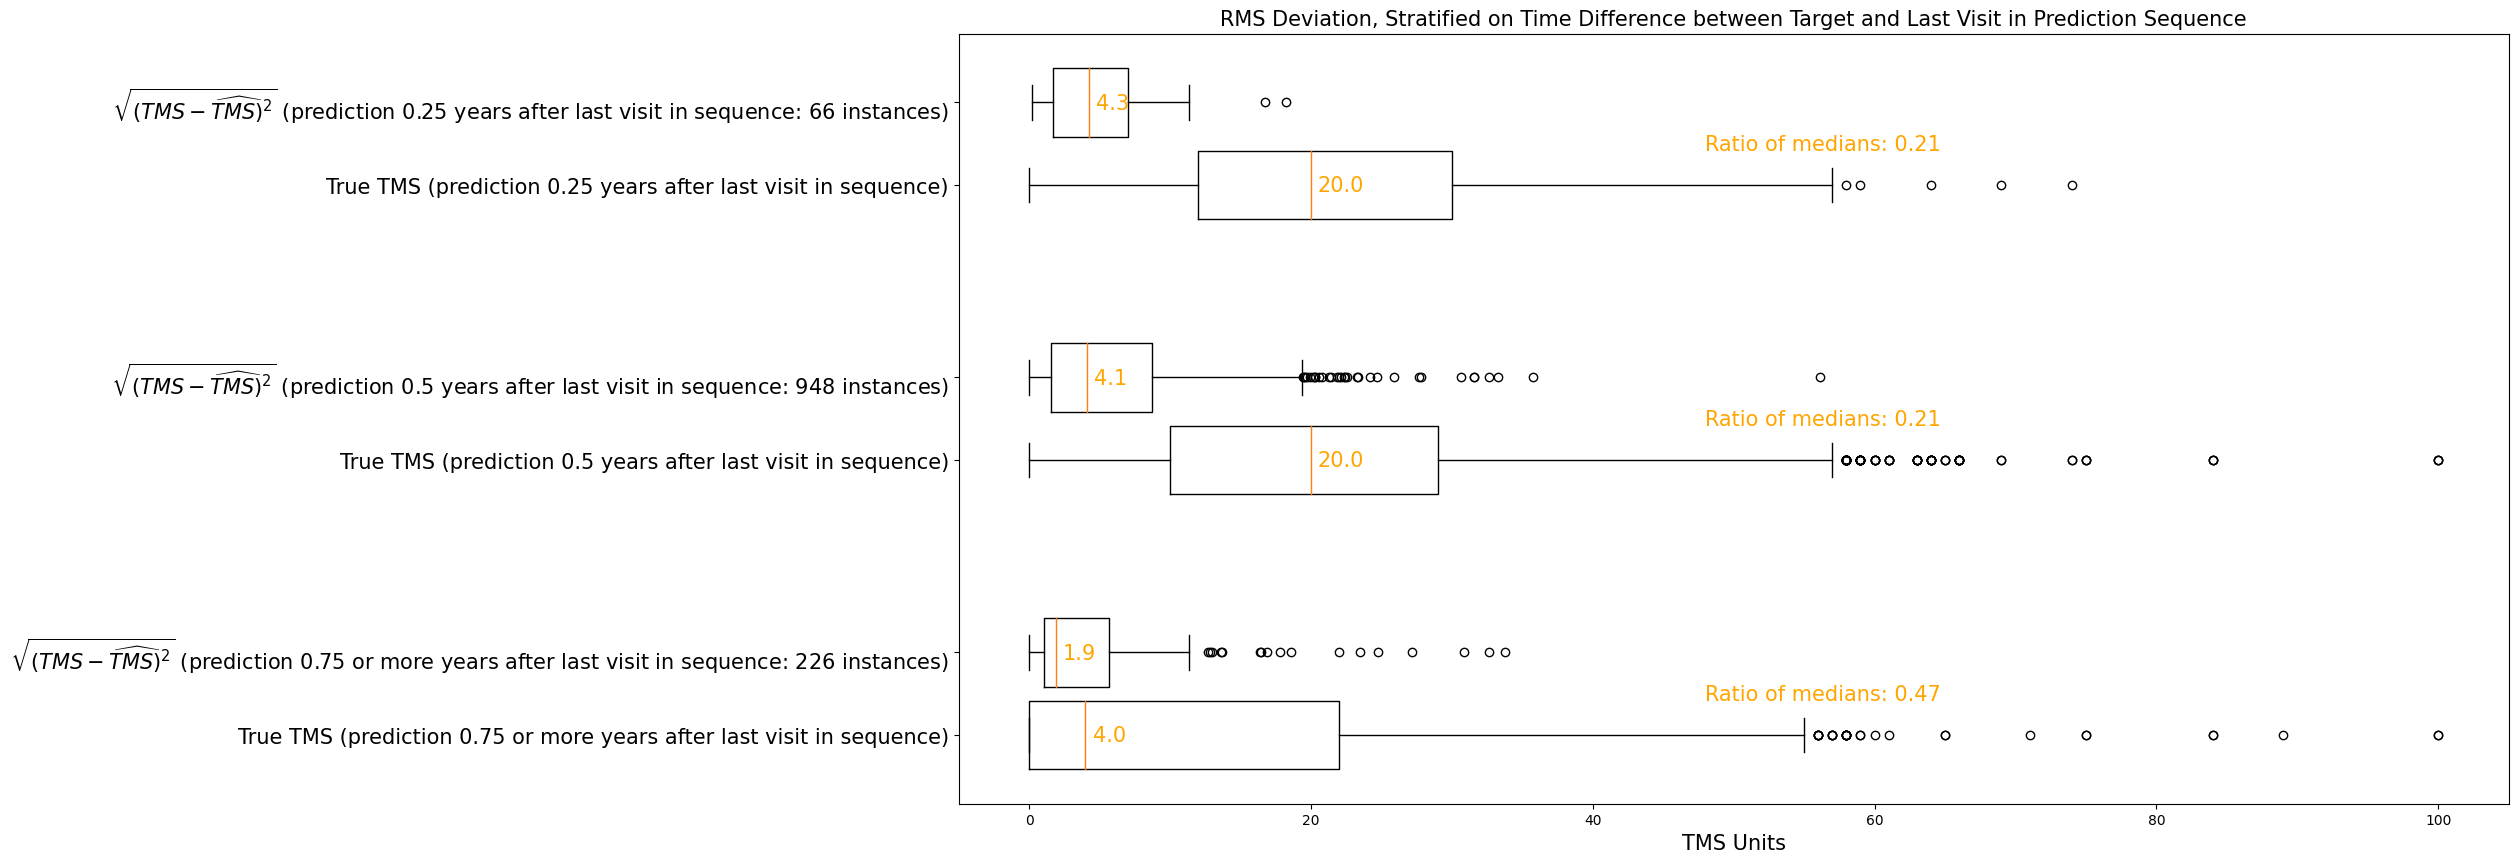

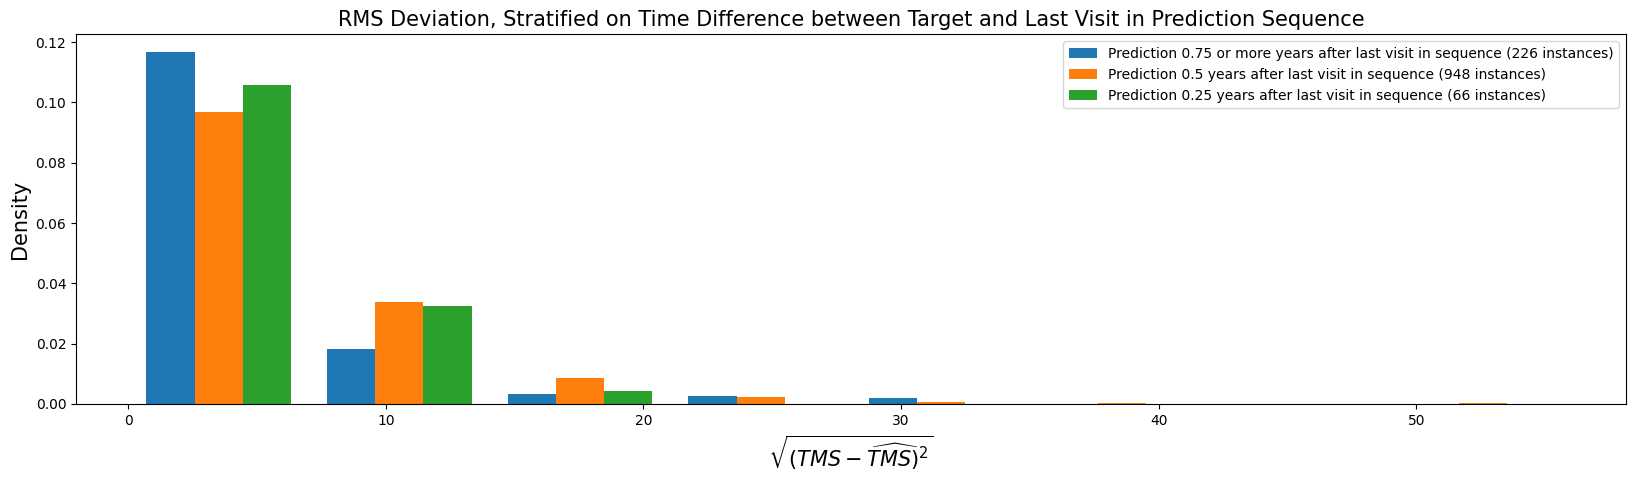

In [ ]:
# Stratifying RMS on time of prediction since last visit used in prediction

rms_tu_025 = np.empty(0)
rms_tu_05 = np.empty(0)
rms_tu_075 = np.empty(0)

tms_tu_025 = np.empty(0)
tms_tu_05 = np.empty(0)
tms_tu_075 = np.empty(0)

tdiff_025 = np.empty(0)
tdiff_05 = np.empty(0)
tdiff_075 = np.empty(0)

for key in patient_level_results:
  all_seq_times = patient_level_results[key]['seq_times']
  all_target_times = patient_level_results[key]['target_times']
  all_sqdev = patient_level_results[key]['sqdev']
  for i in range(len(all_target_times)):
    seq_t = all_seq_times[i]
    last_seq_t = seq_t[-1]
    t = all_target_times[i]
    t_diff = t - last_seq_t
    rms = np.sqrt(all_sqdev[i])

    if t_diff == 0.25:
      tdiff_025 = np.concatenate((tdiff_025, [t_diff]))
      rms_tu_025 = np.concatenate((rms_tu_025, [rms]))
      tms_tu_025 = np.concatenate((tms_tu_025, patient_level_results[key]['all_tms']))
    elif t_diff == 0.5:
      tdiff_05 = np.concatenate((tdiff_05, [t_diff]))
      rms_tu_05 = np.concatenate((rms_tu_05, [rms]))
      tms_tu_05 = np.concatenate((tms_tu_05, patient_level_results[key]['all_tms']))
    elif t_diff >= 0.75:
      tdiff_075 = np.concatenate((tdiff_075, [t_diff]))
      rms_tu_075 = np.concatenate((rms_tu_075, [rms]))
      tms_tu_075 = np.concatenate((tms_tu_075, patient_level_results[key]['all_tms']))

rms_tms_tu_dict = {"True TMS (prediction 0.75 or more years after last visit in sequence)":tms_tu_075,
               r"$\sqrt{(TMS - \widehat{TMS})^2}$ (prediction 0.75 or more years after last visit in sequence: %i instances)" % len(rms_tu_075):rms_tu_075,
               "True TMS (prediction 0.5 years after last visit in sequence)":tms_tu_05,
               r"$\sqrt{(TMS - \widehat{TMS})^2}$ (prediction 0.5 years after last visit in sequence: %i instances)" % len(rms_tu_05):rms_tu_05,
               "True TMS (prediction 0.25 years after last visit in sequence)":tms_tu_025,
               r"$\sqrt{(TMS - \widehat{TMS})^2}$ (prediction 0.25 years after last visit in sequence: %i instances)" % len(rms_tu_025):rms_tu_025}

rms_tu_dict = {f"Prediction 0.75 or more years after last visit in sequence ({len(rms_tu_075)} instances)":rms_tu_075,
               f"Prediction 0.5 years after last visit in sequence ({len(rms_tu_05)} instances)":rms_tu_05,
               f"Prediction 0.25 years after last visit in sequence ({len(rms_tu_025)} instances)":rms_tu_025}

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
ax.boxplot(rms_tms_tu_dict.values(), vert = False, positions = [1, 1.6, 3, 3.6, 5, 5.6]);
ax.set_xlabel("TMS Units", size = 15);
ax.set_yticklabels(rms_tms_tu_dict.keys(), fontsize = 15);
ax.set_title("RMS Deviation, Stratified on Time Difference between Target and Last Visit in Prediction Sequence", size = 15);

ax.text(boxplot_stats(rms_tu_025)[0]['med'] + 0.5, 5.55, round(boxplot_stats(rms_tu_025)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(tms_tu_025)[0]['med'] + 0.5, 4.95, round(boxplot_stats(tms_tu_025)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 5.25, f"Ratio of medians: {np.round(boxplot_stats(rms_tu_025)[0]['med'] / boxplot_stats(tms_tu_025)[0]['med'], 2)}", color = 'orange', fontsize = 15)

ax.text(boxplot_stats(rms_tu_05)[0]['med'] + 0.5, 3.55, round(boxplot_stats(rms_tu_05)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(tms_tu_05)[0]['med'] + 0.5, 2.95, round(boxplot_stats(tms_tu_05)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 3.25, f"Ratio of medians: {np.round(boxplot_stats(rms_tu_05)[0]['med'] / boxplot_stats(tms_tu_05)[0]['med'], 2)}", color = 'orange', fontsize = 15)

ax.text(boxplot_stats(rms_tu_075)[0]['med'] + 0.5, 1.55, round(boxplot_stats(rms_tu_075)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(tms_tu_075)[0]['med'] + 0.5, 0.95, round(boxplot_stats(tms_tu_075)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 1.25, f"Ratio of medians: {np.round(boxplot_stats(rms_tu_075)[0]['med'] / boxplot_stats(tms_tu_075)[0]['med'], 2)}", color = 'orange', fontsize = 15)

fig, ax2 = plt.subplots()
fig.set_figwidth(20)
ax2.hist(rms_tu_dict.values(), label = list(rms_tu_dict.keys()), bins = 8, density = True);
ax2.set_xlabel(r"$\sqrt{(TMS - \widehat{TMS})^2}$", size = 15);
ax2.set_ylabel("Density", size = 15)
ax2.set_title("RMS Deviation, Stratified on Time Difference between Target and Last Visit in Prediction Sequence", size = 15);
ax2.legend();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


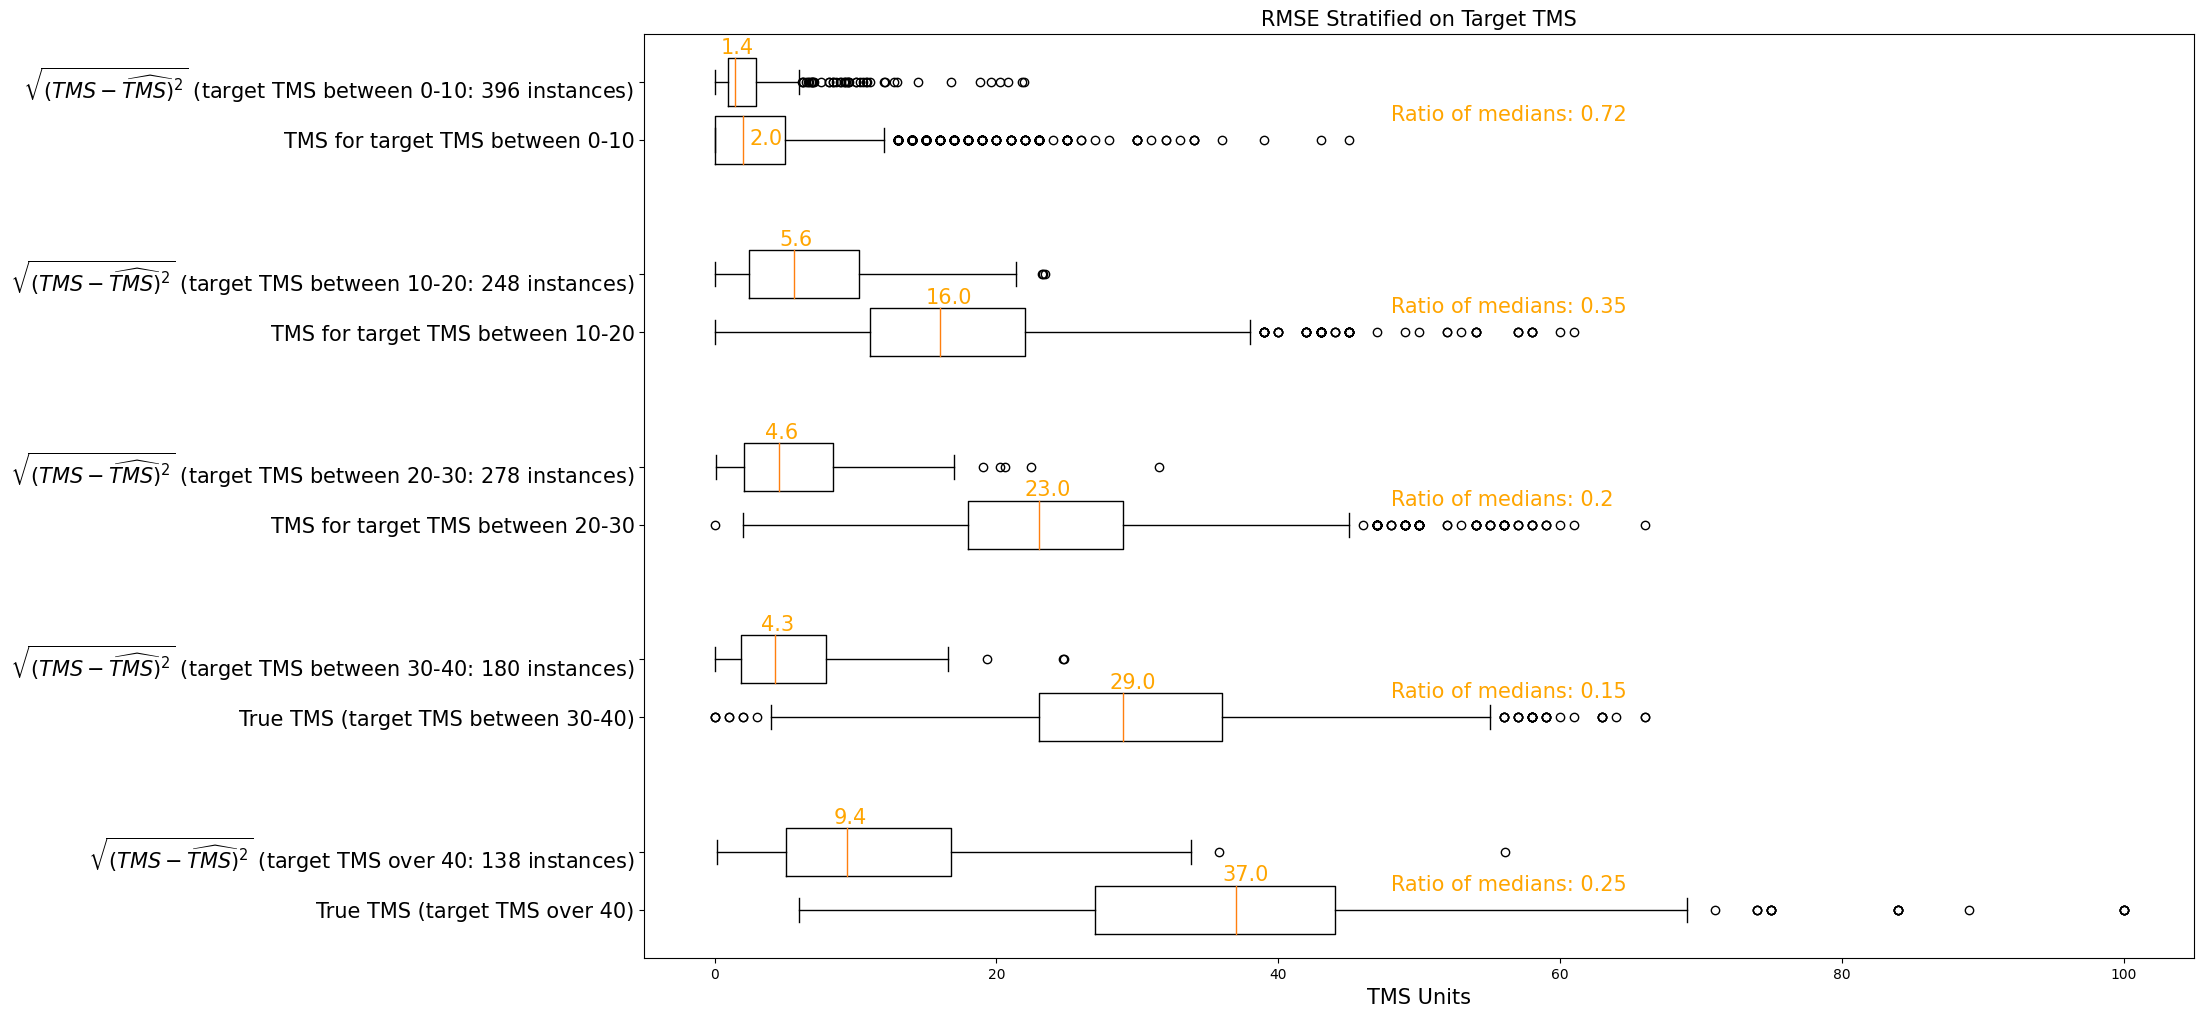

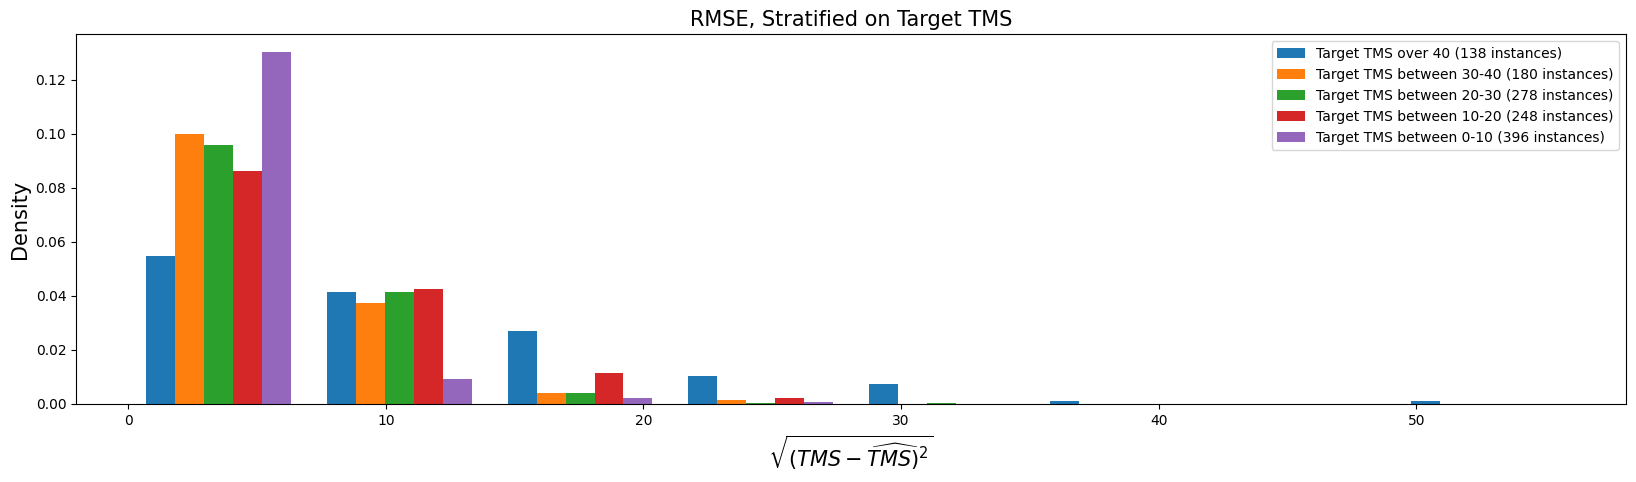

In [ ]:
# Stratifying RMS on target TMS

rms_tms0_10 = np.empty(0)
rms_tms10_20 = np.empty(0)
rms_tms20_30 = np.empty(0)
rms_tms30_40 = np.empty(0)
rms_tms40 = np.empty(0)
tms0_10 = np.empty(0)
tms10_20 = np.empty(0)
tms20_30 = np.empty(0)
tms30_40 = np.empty(0)
tms40 = np.empty(0)

for key in patient_level_results:
  all_target_tms = patient_level_results[key]['target_TMS']
  all_sqdev = patient_level_results[key]['sqdev']
  for i in range(len(all_target_tms)):
    tms = all_target_tms[i]
    rms = np.sqrt(all_sqdev[i])
    if tms >= 0 and tms < 10:
      rms_tms0_10 = np.concatenate((rms_tms0_10, [rms]))
      tms0_10 = np.concatenate((tms0_10, patient_level_results[key]['all_tms']))
    elif tms >= 10 and tms < 20:
      rms_tms10_20 = np.concatenate((rms_tms10_20, [rms]))
      tms10_20 = np.concatenate((tms10_20, patient_level_results[key]['all_tms']))
    elif tms >= 20 and tms < 30:
      rms_tms20_30 = np.concatenate((rms_tms20_30, [rms]))
      tms20_30 = np.concatenate((tms20_30, patient_level_results[key]['all_tms']))
    elif tms >= 30 and tms < 40:
      rms_tms30_40 = np.concatenate((rms_tms30_40, [rms]))
      tms30_40 = np.concatenate((tms30_40, patient_level_results[key]['all_tms']))
    elif tms >= 40:
      rms_tms40 = np.concatenate((rms_tms40, [rms]))
      tms40 = np.concatenate((tms40, patient_level_results[key]['all_tms']))


rms_tms_all_tms_dict = {"True TMS (target TMS over 40)":tms40,
                        r"$\sqrt{(TMS - \widehat{TMS})^2}$ (target TMS over 40: %i instances)" % len(rms_tms40):rms_tms40,
                        "True TMS (target TMS between 30-40)":tms30_40,
                        r"$\sqrt{(TMS - \widehat{TMS})^2}$ (target TMS between 30-40: %i instances)" % len(rms_tms30_40):rms_tms30_40,
                        "TMS for target TMS between 20-30":tms20_30,
                        r"$\sqrt{(TMS - \widehat{TMS})^2}$ (target TMS between 20-30: %i instances)" % len(rms_tms20_30):rms_tms20_30,
                        "TMS for target TMS between 10-20":tms10_20,
                        r"$\sqrt{(TMS - \widehat{TMS})^2}$ (target TMS between 10-20: %i instances)" % len(rms_tms10_20):rms_tms10_20,
                        "TMS for target TMS between 0-10":tms0_10,
                        r"$\sqrt{(TMS - \widehat{TMS})^2}$ (target TMS between 0-10: %i instances)" % len(rms_tms0_10):rms_tms0_10}

rms_tms_dict = {f"Target TMS over 40 ({len(rms_tms40)} instances)":rms_tms40,
                f"Target TMS between 30-40 ({len(rms_tms30_40)} instances)":rms_tms30_40,
                f"Target TMS between 20-30 ({len(rms_tms20_30)} instances)":rms_tms20_30,
                f"Target TMS between 10-20 ({len(rms_tms10_20)} instances)":rms_tms10_20,
                f"Target TMS between 0-10 ({len(rms_tms0_10)} instances)":rms_tms0_10}

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(12)
ax.boxplot(rms_tms_all_tms_dict.values(), vert = False, positions = [1, 1.6, 3, 3.6, 5, 5.6, 7, 7.6, 9, 9.6]);
ax.set_xlabel("TMS Units", size = 15);
ax.set_yticklabels(rms_tms_all_tms_dict.keys(), fontsize = 15);
ax.set_title("RMSE Stratified on Target TMS", size = 15);

ax.text(boxplot_stats(rms_tms0_10)[0]['med'] - 1, 9.9, round(boxplot_stats(rms_tms0_10)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(tms0_10)[0]['med'] + 0.5, 8.95, round(boxplot_stats(tms0_10)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 9.2, f"Ratio of medians: {np.round(boxplot_stats(rms_tms0_10)[0]['med']/boxplot_stats(tms0_10)[0]['med'], 2)}", color = 'orange', fontsize = 15)

ax.text(boxplot_stats(rms_tms10_20)[0]['med'] - 1, 7.9, round(boxplot_stats(rms_tms10_20)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(tms10_20)[0]['med'] - 1, 7.3, round(boxplot_stats(tms10_20)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 7.2, f"Ratio of medians: {np.round(boxplot_stats(rms_tms10_20)[0]['med']/boxplot_stats(tms10_20)[0]['med'], 2)}", color = 'orange', fontsize = 15)

ax.text(boxplot_stats(rms_tms20_30)[0]['med'] - 1, 5.9, round(boxplot_stats(rms_tms20_30)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(tms20_30)[0]['med'] - 1, 5.3, round(boxplot_stats(tms20_30)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 5.2, f"Ratio of medians: {np.round(boxplot_stats(rms_tms20_30)[0]['med']/boxplot_stats(tms20_30)[0]['med'], 2)}", color = 'orange', fontsize = 15)

ax.text(boxplot_stats(rms_tms30_40)[0]['med'] - 1, 3.9, round(boxplot_stats(rms_tms30_40)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(tms30_40)[0]['med'] - 1, 3.3, round(boxplot_stats(tms30_40)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 3.2, f"Ratio of medians: {np.round(boxplot_stats(rms_tms30_40)[0]['med']/boxplot_stats(tms30_40)[0]['med'], 2)}", color = 'orange', fontsize = 15)

ax.text(boxplot_stats(rms_tms40)[0]['med'] - 1, 1.9, round(boxplot_stats(rms_tms40)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(tms40)[0]['med'] - 1, 1.3, round(boxplot_stats(tms40)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 1.2, f"Ratio of medians: {np.round(boxplot_stats(rms_tms40)[0]['med']/boxplot_stats(tms40)[0]['med'], 2)}", color = 'orange', fontsize = 15)

fig, ax2 = plt.subplots()
fig.set_figwidth(20)
ax2.hist(rms_tms_dict.values(), label = list(rms_tms_dict.keys()), bins = 8, density = True);
ax2.set_xlabel(r"$\sqrt{(TMS - \widehat{TMS})^2}$", size = 15);
ax2.set_ylabel("Density", size = 15)
ax2.set_title("RMSE, Stratified on Target TMS", size = 15);
ax2.legend();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(48, 1.5, 'Ratio of medians: 0.4')

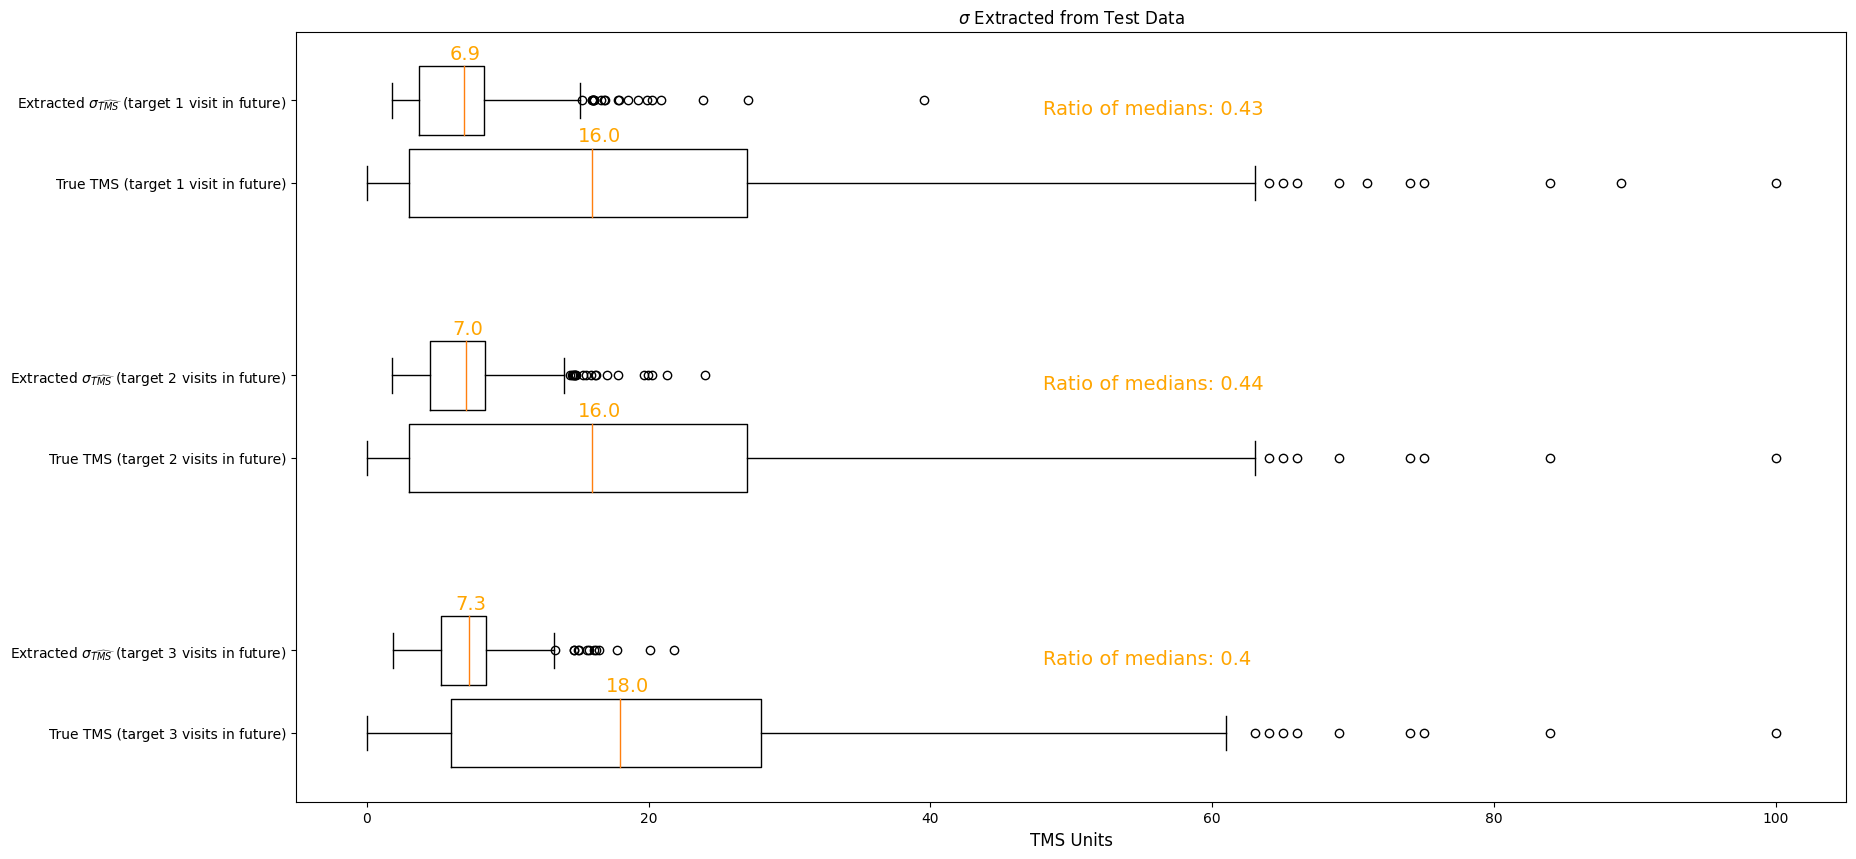

In [ ]:
# Distribution of predicted sigma

sigma = np.empty(0)
ext_2_sigma = np.empty(0)
ext_3_sigma = np.empty(0)

tms = np.empty(0)
ext_2_tms = np.empty(0)
ext_3_tms = np.empty(0)

for k in patient_level_results:
  sigma = np.concatenate((sigma, patient_level_results[k]["pred_sigma"]))
  tms = np.concatenate((tms, patient_level_results[k]["all_tms"]))

for k in ext_2_patient_level_results:
  ext_2_sigma = np.concatenate((ext_2_sigma, ext_2_patient_level_results[k]["pred_sigma"]))
  ext_2_tms = np.concatenate((ext_2_tms, patient_level_results[k]["all_tms"]))

for k in ext_3_patient_level_results:
  ext_3_sigma = np.concatenate((ext_3_sigma, ext_3_patient_level_results[k]["pred_sigma"]))
  ext_3_tms = np.concatenate((ext_3_tms, patient_level_results[k]["all_tms"]))

sigma_tms_dict = {"True TMS (target 3 visits in future)":ext_3_tms,
              r"Extracted $\sigma_{\widehat{TMS}}$ (target 3 visits in future)":ext_3_sigma,
              "True TMS (target 2 visits in future)":ext_2_tms,
              r"Extracted $\sigma_{\widehat{TMS}}$ (target 2 visits in future)":ext_2_sigma,
              "True TMS (target 1 visit in future)":tms,
              r"Extracted $\sigma_{\widehat{TMS}}$ (target 1 visit in future)":sigma}

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
ax.boxplot(sigma_tms_dict.values(), vert = False, positions = [1, 1.6, 3, 3.6, 5, 5.6]);
ax.set_xlabel("TMS Units", size = 12);
#ax.set_xlabel(r"Extracted $\sigma_{\widehat{TMS}}$", size = 12);
ax.set_yticklabels(sigma_tms_dict.keys())
ax.set_title(r"$\sigma$ Extracted from Test Data", size = 12);

ax.text(boxplot_stats(sigma)[0]['med'] - 1, 5.9, round(boxplot_stats(sigma)[0]['med'], 1), color = 'orange', fontsize = 14)
ax.text(boxplot_stats(tms)[0]['med'] - 1, 5.3, round(boxplot_stats(tms)[0]['med'], 1), color = 'orange', fontsize = 14)
ax.text(48, 5.5, f"Ratio of medians: {np.round(boxplot_stats(sigma)[0]['med']/boxplot_stats(tms)[0]['med'], 2)}", color = 'orange', fontsize = 14)

ax.text(boxplot_stats(ext_2_sigma)[0]['med'] - 1, 3.9, round(boxplot_stats(ext_2_sigma)[0]['med'], 1), color = 'orange', fontsize = 14)
ax.text(boxplot_stats(ext_2_tms)[0]['med'] - 1, 3.3, round(boxplot_stats(ext_2_tms)[0]['med'], 1), color = 'orange', fontsize = 14)
ax.text(48, 3.5, f"Ratio of medians: {np.round(boxplot_stats(ext_2_sigma)[0]['med']/boxplot_stats(ext_2_tms)[0]['med'], 2)}", color = 'orange', fontsize = 14)

ax.text(boxplot_stats(ext_3_sigma)[0]['med'] - 1, 1.9, round(boxplot_stats(ext_3_sigma)[0]['med'], 1), color = 'orange', fontsize = 14)
ax.text(boxplot_stats(ext_3_tms)[0]['med'] - 1, 1.3, round(boxplot_stats(ext_3_tms)[0]['med'], 1), color = 'orange', fontsize = 14)
ax.text(48, 1.5, f"Ratio of medians: {np.round(boxplot_stats(ext_3_sigma)[0]['med']/boxplot_stats(ext_3_tms)[0]['med'], 2)}", color = 'orange', fontsize = 14)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


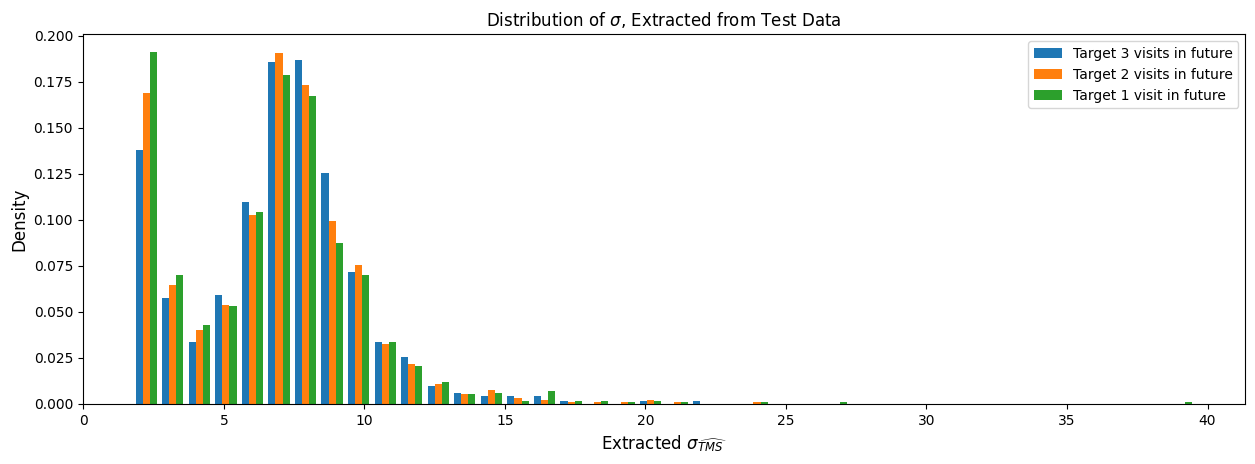

In [ ]:
sigma_dict = {"Target 3 visits in future":ext_3_sigma,
              "Target 2 visits in future":ext_2_sigma,
              "Target 1 visit in future":sigma}

fig, ax = plt.subplots()
fig.set_figwidth(15)
ax.hist(sigma_dict.values(), bins=40, density = True, label = list(sigma_dict.keys()));
ax.set_xlabel(r"Extracted $\sigma_{\widehat{TMS}}$", size = 12);
ax.set_ylabel("Density", size = 12);
ax.set_title(r"Distribution of $\sigma$, Extracted from Test Data", size = 12);
ax.legend()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Within 2 sigma 41.16 % of instance
Within 3 sigma 57.4 % of instance


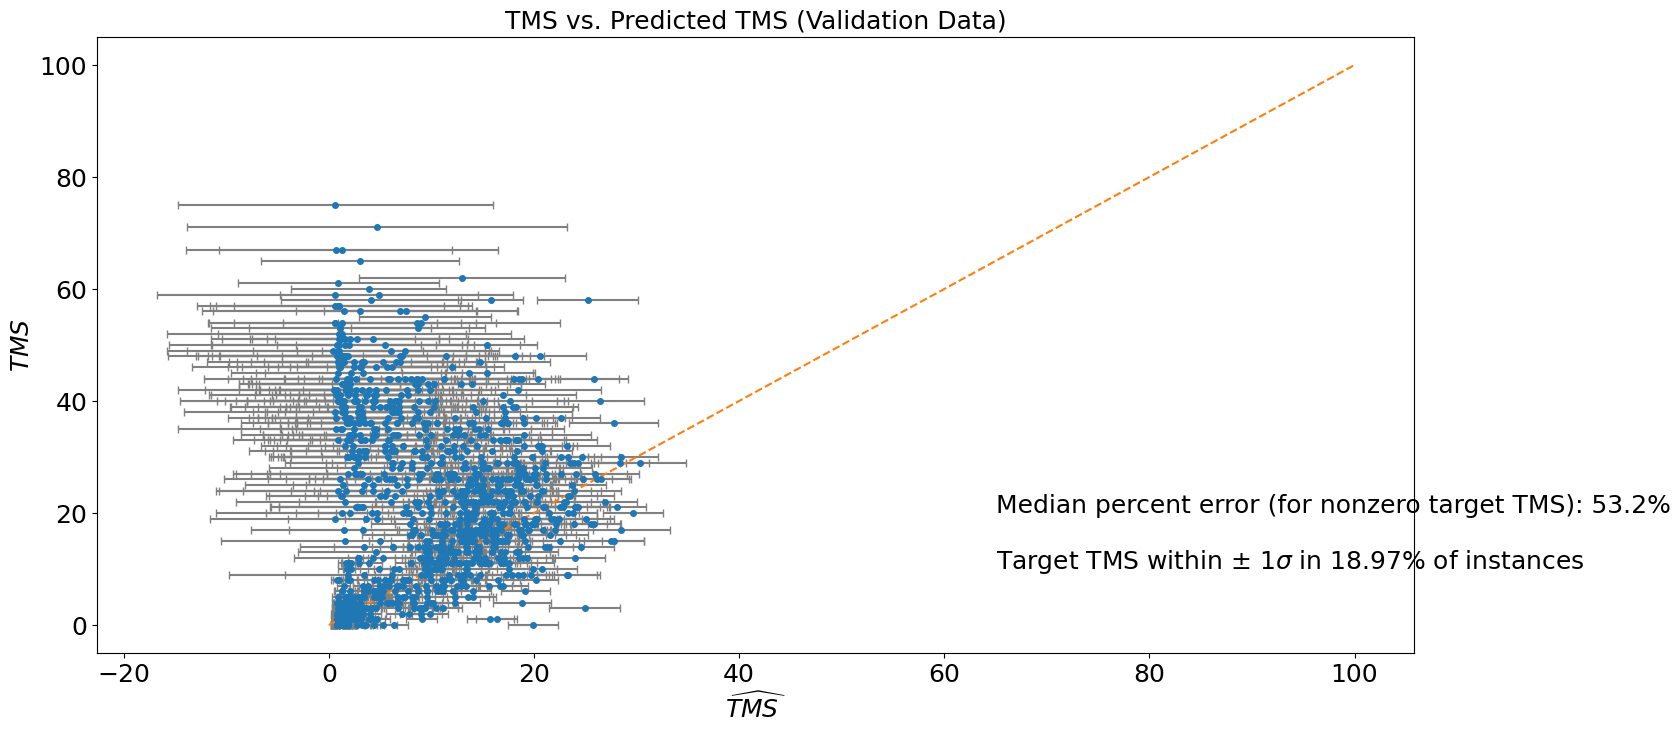

In [ ]:
# Scatter plot true vs. predicted TMS

target_tms = np.empty(0)
pred_tms = np.empty(0)
sigma = np.empty(0)

for k in patient_level_results:
  target_tms = np.concatenate((target_tms, patient_level_results[k]["target_TMS"]))
  pred_tms = np.concatenate((pred_tms, patient_level_results[k]["pred_TMS"]))
  sigma = np.concatenate((sigma, patient_level_results[k]["pred_sigma"]))

idx_nonzero = np.where(target_tms != 0)
p_err_nonzero = np.median(np.abs(target_tms[idx_nonzero] - pred_tms[idx_nonzero])/target_tms[idx_nonzero]) * 100

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(17)
ax.errorbar(pred_tms, target_tms, xerr = sigma, fmt = "o", ecolor = 'grey', markersize = 4, capsize = 3)

x = np.linspace(0, 100, 100)
ax.plot(x, x, linestyle = '--')

ax.set_xlabel(r"$\widehat{TMS}$", size = 18)
ax.set_ylabel(r"$TMS$", size = 18)
ax.set_title("TMS vs. Predicted TMS (Validation Data)", size = 18)

below_upper = target_tms <= pred_tms + sigma
above_lower = target_tms >= pred_tms - sigma
inside = np.logical_and(below_upper, above_lower)

below_upper_2 = target_tms <= pred_tms + 2 * sigma
above_lower_2 = target_tms >= pred_tms - 2 * sigma
inside_2 = np.logical_and(below_upper_2, above_lower_2)
within_2_sigma = inside_2.sum() / len(inside_2) * 100

below_upper_3 = target_tms <= pred_tms + 3 * sigma
above_lower_3 = target_tms >= pred_tms - 3 * sigma
inside_3 = np.logical_and(below_upper_3, above_lower_3)
within_3_sigma = inside_3.sum() / len(inside_3) * 100

print(f'Within 2 sigma {str(np.round(within_2_sigma, 2))} % of instance')

print(f'Within 3 sigma {str(np.round(within_3_sigma, 2))} % of instance')

within_sigma = inside.sum() / len(inside) * 100
ax.text(65, 10, r"Target TMS within $\pm$ 1$\sigma$ in " + str(np.round(within_sigma, 2)) + "% of instances", size = 18);
ax.text(65, 20, f'Median percent error (for nonzero target TMS): {np.round(p_err_nonzero, 2)}%', size = 18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


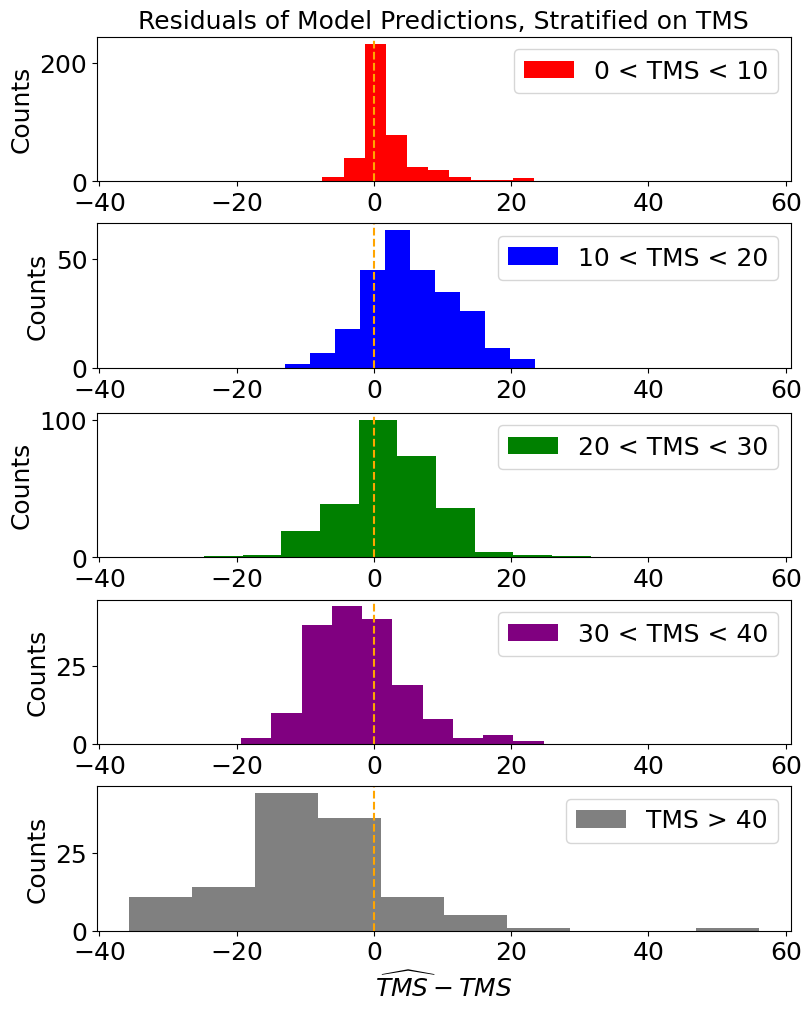

In [ ]:
# Plot the residuals: TMS_hat - TMS
# Stratify over the target TMS

idx0_10 = np.where(target_tms <= 10)
idx10_20 = np.where((target_tms > 10) & (target_tms <= 20))
idx20_30 = np.where((target_tms > 20) & (target_tms <= 30))
idx30_40 = np.where((target_tms > 30) & (target_tms <= 40))
idx40 = np.where(target_tms > 40)

tms_res0_10 = pred_tms[idx0_10] - target_tms[idx0_10]
tms_res10_20 = pred_tms[idx10_20] - target_tms[idx10_20]
tms_res20_30 = pred_tms[idx20_30] - target_tms[idx20_30]
tms_res30_40 = pred_tms[idx30_40] - target_tms[idx30_40]
tms_res40 = pred_tms[idx40] - target_tms[idx40]


res_dict = {"0-10":tms_res0_10,
            "10-20":tms_res10_20,
            "20-30":tms_res20_30,
            "30-40":tms_res30_40,
            "40+":tms_res40}


fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, ncols=1, sharex=True, constrained_layout=True)
fig.set_figwidth(8)
fig.set_figheight(10)

ax0.hist(tms_res0_10, density = False, bins = 10, color = 'red', label = '0 < TMS < 10')
ax1.hist(tms_res10_20, density = False, bins = 10, color = 'blue', label = '10 < TMS < 20')
ax2.hist(tms_res20_30, density = False, bins = 10, color = 'green', label = '20 < TMS < 30')
ax3.hist(tms_res30_40, density = False, bins = 10, color = 'purple', label = '30 < TMS < 40')
ax4.hist(tms_res40, density = False, bins = 10, color = 'grey', label = 'TMS > 40')
ax0.axvline(0, linestyle = '--', color = 'orange')
ax1.axvline(0, linestyle = '--', color = 'orange')
ax2.axvline(0, linestyle = '--', color = 'orange')
ax3.axvline(0, linestyle = '--', color = 'orange')
ax4.axvline(0, linestyle = '--', color = 'orange')
ax0.xaxis.set_tick_params(which='both', labelbottom=True)
ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax2.xaxis.set_tick_params(which='both', labelbottom=True)
ax3.xaxis.set_tick_params(which='both', labelbottom=True)
ax4.set_xlabel(r'$\widehat{TMS} - TMS$', size=18)
ax0.set_ylabel('Counts', size=18)
ax1.set_ylabel('Counts', size=18)
ax2.set_ylabel('Counts', size=18)
ax3.set_ylabel('Counts', size=18)
ax4.set_ylabel('Counts', size=18)
ax0.legend(fontsize=18)
ax1.legend(fontsize=18)
ax2.legend(fontsize=18)
ax3.legend(fontsize=18)
ax4.legend(fontsize=18)
ax0.set_title('Residuals of Model Predictions, Stratified on TMS', size=18)
ax0.tick_params(axis='x', labelsize=18)
ax0.tick_params(axis='y', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax3.tick_params(axis='x', labelsize=18)
ax3.tick_params(axis='y', labelsize=18)
ax4.tick_params(axis='x', labelsize=18)
ax4.tick_params(axis='y', labelsize=18)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


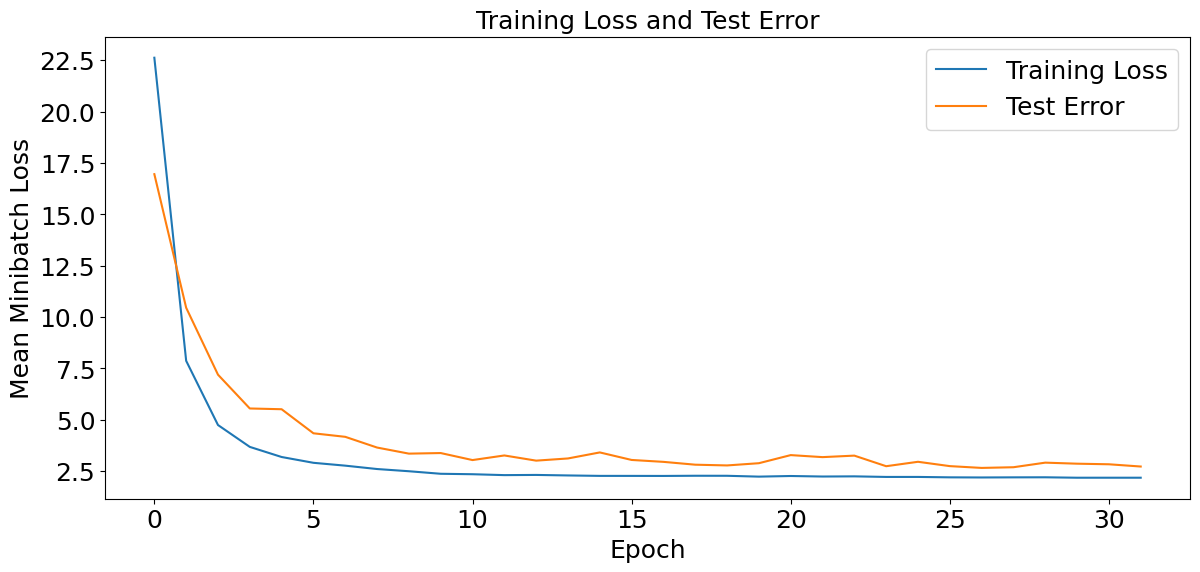

In [ ]:
low = 10
high = len(train_loss_list)

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(14)

#left, bottom, width, height = [0.25, 0.3, 0.2, 0.4]
#inset = fig.add_axes([left, bottom, width, height])
ax.plot(np.arange(0, len(train_loss_list)), train_loss_list, label = "Training Loss")
ax.plot(np.arange(0, len(test_error_list)), test_error_list, label = "Test Error")
ax.set_title("Training Loss and Test Error", size = 18)
ax.set_xlabel("Epoch", size = 18)
ax.set_ylabel("Mean Minibatch Loss", size = 18)
#inset.plot(np.arange(low, high), train_loss_list[low:high])
#inset.plot(np.arange(low, high), test_error_list[low:high])
ax.legend(fontsize = 18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(48, 1.25, 'Ratio of medians: 0.25')

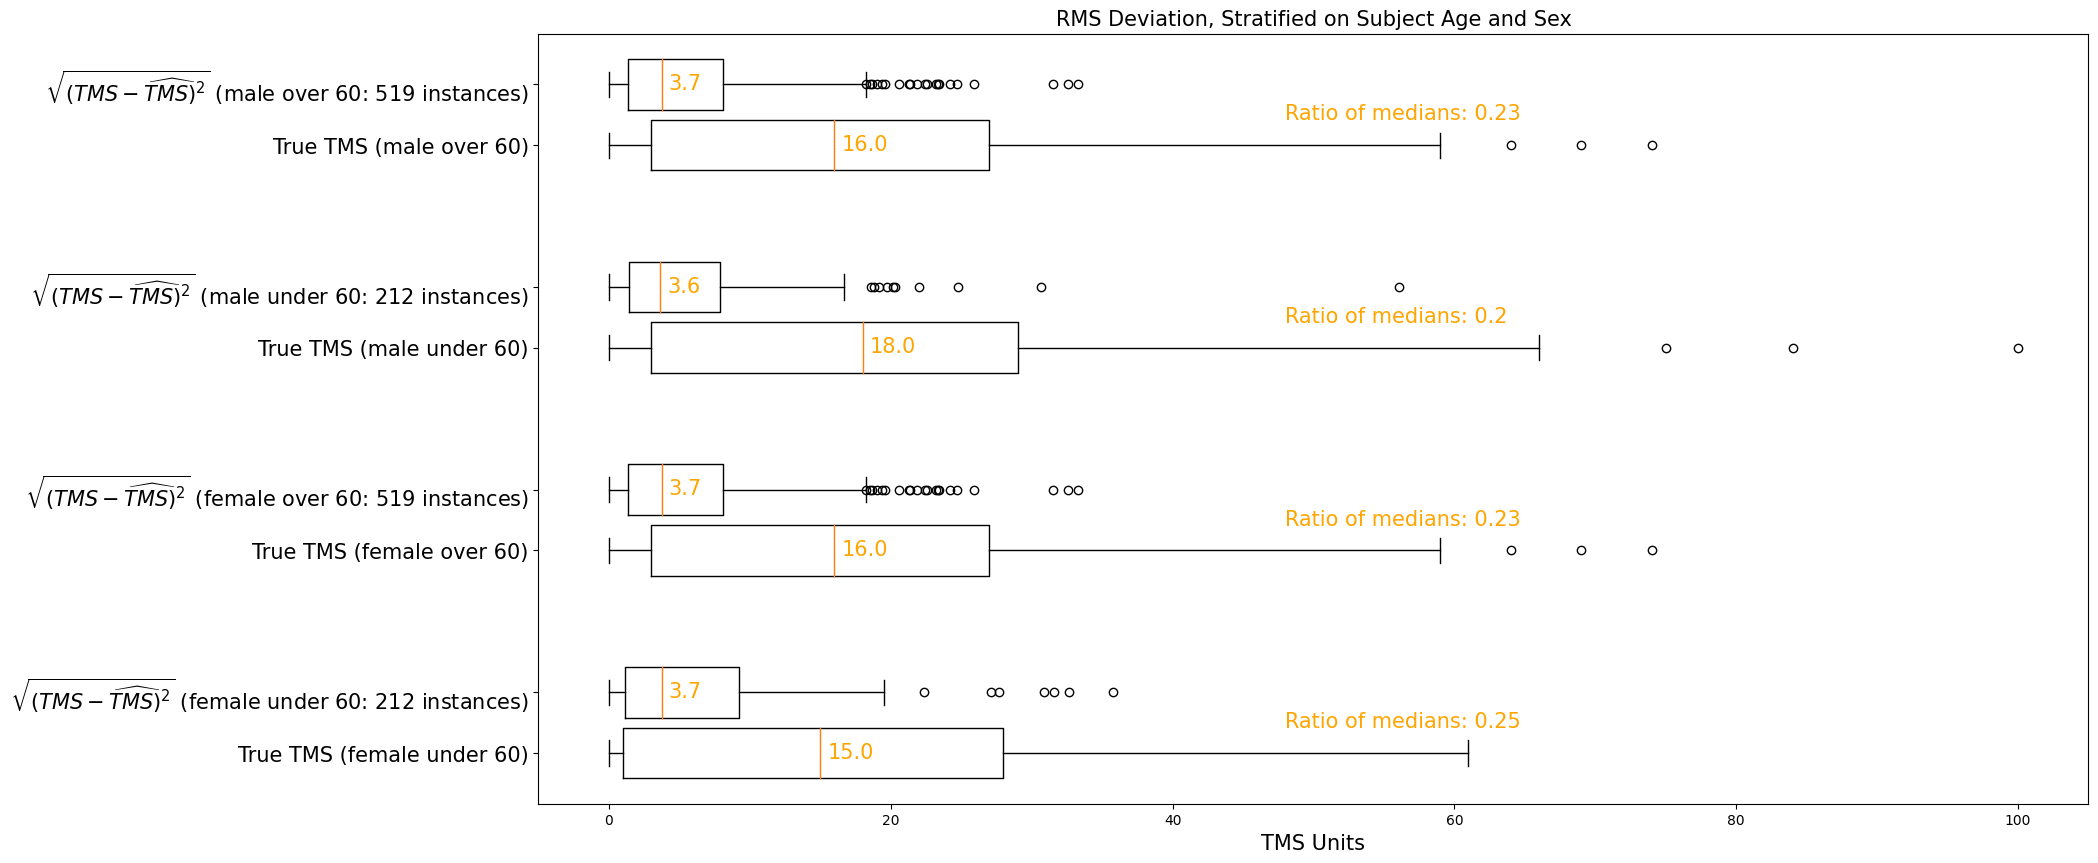

In [ ]:
male_a_rms = np.empty(0)
male_a_tms = np.empty(0)
male_u_rms = np.empty(0)
male_u_tms = np.empty(0)
female_a_rms = np.empty(0)
female_a_tms = np.empty(0)
female_u_rms = np.empty(0)
female_u_tms = np.empty(0)

for k in patient_level_results:
  age = patient_level_results[k]["age"]
  sex = patient_level_results[k]["sex"]

  if sex == 1. and age < 60:
    male_u_rms = np.concatenate((male_u_rms, np.sqrt(patient_level_results[k]["sqdev"])))
    male_u_tms = np.concatenate((male_u_tms, patient_level_results[k]["all_tms"]))
  elif sex == 1. and age >= 60:
    male_a_rms = np.concatenate((male_a_rms, np.sqrt(patient_level_results[k]["sqdev"])))
    male_a_tms = np.concatenate((male_a_tms, patient_level_results[k]["all_tms"]))
  elif sex == 0 and age < 60:
    female_u_rms = np.concatenate((female_u_rms, np.sqrt(patient_level_results[k]["sqdev"])))
    female_u_tms = np.concatenate((female_u_tms, patient_level_results[k]["all_tms"]))
  else:
    female_a_rms = np.concatenate((male_a_rms, np.sqrt(patient_level_results[k]["sqdev"])))
    female_a_tms = np.concatenate((male_a_tms, patient_level_results[k]["all_tms"]))

age_sex_rms_tms_dict = {"True TMS (female under 60)":female_u_tms,
                    r"$\sqrt{(TMS - \widehat{TMS})^2}$ (female under 60: %i instances)" % len(female_u_rms):female_u_rms,
                    "True TMS (female over 60)":female_a_tms,
                    r"$\sqrt{(TMS - \widehat{TMS})^2}$ (female over 60: %i instances)" % len(female_a_rms):female_a_rms,
                    "True TMS (male under 60)":male_u_tms,
                    r"$\sqrt{(TMS - \widehat{TMS})^2}$ (male under 60: %i instances)" % len(male_u_rms):male_u_rms,
                    "True TMS (male over 60)":male_a_tms,
                    r"$\sqrt{(TMS - \widehat{TMS})^2}$ (male over 60: %i instances)" % len(male_a_rms):male_a_rms}

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
ax.boxplot(age_sex_rms_tms_dict.values(), vert = False, positions = [1, 1.6, 3, 3.6, 5, 5.6, 7, 7.6]);
ax.set_xlabel("TMS Units", size = 15);
ax.set_yticklabels(age_sex_rms_tms_dict.keys(), fontsize = 15);
ax.set_title("RMS Deviation, Stratified on Subject Age and Sex", size = 15);

ax.text(boxplot_stats(male_a_rms)[0]['med'] + 0.5, 7.55, round(boxplot_stats(male_a_rms)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(male_a_tms)[0]['med'] + 0.5, 6.95, round(boxplot_stats(male_a_tms)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 7.25, f"Ratio of medians: {round(boxplot_stats(male_a_rms)[0]['med'] / boxplot_stats(male_a_tms)[0]['med'], 2)}", color = 'orange', fontsize = 15)

ax.text(boxplot_stats(male_u_rms)[0]['med'] + 0.5, 5.55, round(boxplot_stats(male_u_rms)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(male_u_tms)[0]['med'] + 0.5, 4.95, round(boxplot_stats(male_u_tms)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 5.25, f"Ratio of medians: {round(boxplot_stats(male_u_rms)[0]['med'] / boxplot_stats(male_u_tms)[0]['med'], 2)}", color = 'orange', fontsize = 15)

ax.text(boxplot_stats(female_a_rms)[0]['med'] + 0.5, 3.55, round(boxplot_stats(female_a_rms)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(female_a_tms)[0]['med'] + 0.5, 2.95, round(boxplot_stats(female_a_tms)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 3.25, f"Ratio of medians: {round(boxplot_stats(female_a_rms)[0]['med'] / boxplot_stats(female_a_tms)[0]['med'], 2)}", color = 'orange', fontsize = 15)

ax.text(boxplot_stats(female_u_rms)[0]['med'] + 0.5, 1.55, round(boxplot_stats(female_u_rms)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(boxplot_stats(female_u_tms)[0]['med'] + 0.5, 0.95, round(boxplot_stats(female_u_tms)[0]['med'], 1), color = 'orange', fontsize = 15)
ax.text(48, 1.25, f"Ratio of medians: {round(boxplot_stats(female_u_rms)[0]['med'] / boxplot_stats(female_u_tms)[0]['med'], 2)}", color = 'orange', fontsize = 15)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


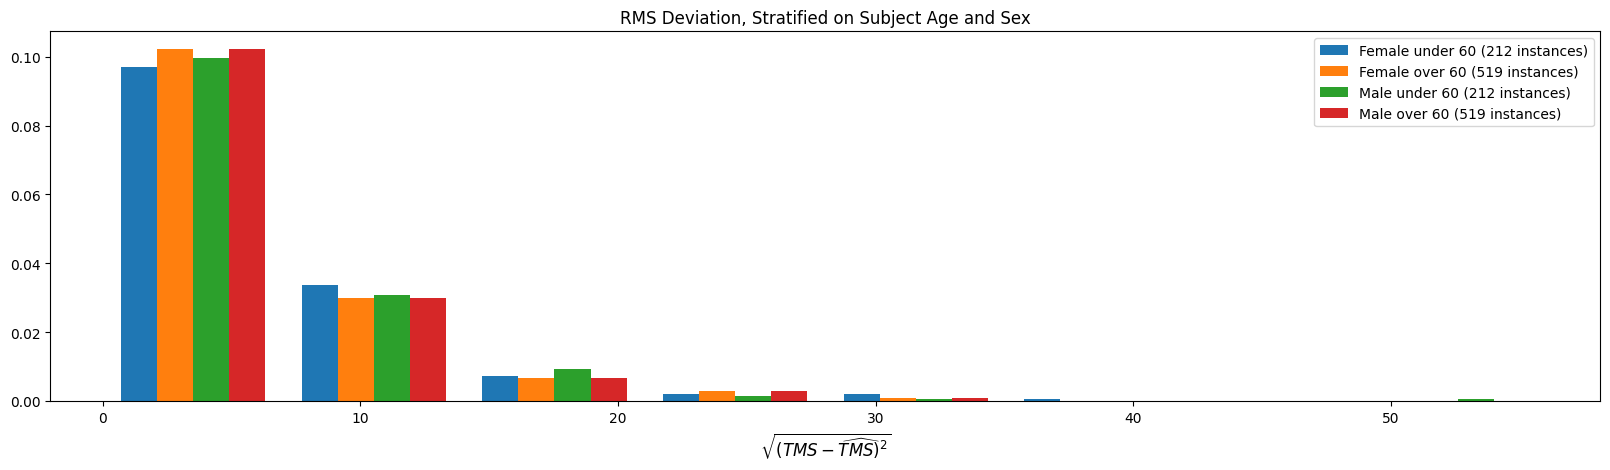

In [ ]:
age_sex_rms_dict = {"Female under 60 (%i instances)" % len(female_u_rms):female_u_rms,
                    "Female over 60 (%i instances)" % len(female_a_rms):female_a_rms,
                    "Male under 60 (%i instances)" % len(male_u_rms):male_u_rms,
                    "Male over 60 (%i instances)" % len(male_a_rms):male_a_rms}

fig, ax = plt.subplots()
fig.set_figwidth(20)
ax.hist(age_sex_rms_dict.values(), label = list(age_sex_rms_dict.keys()), bins = 8, density = True);
ax.set_xlabel(r"$\sqrt{(TMS - \widehat{TMS})^2}$", size = 12);
ax.set_title("RMS Deviation, Stratified on Subject Age and Sex", size = 12);
ax.legend()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(12, 1.5, 'Median of $\\frac{\\sigma_{H_i}}{\\overline{\\mathrm{RMSE}}_{H_i}}$ = 0.74')

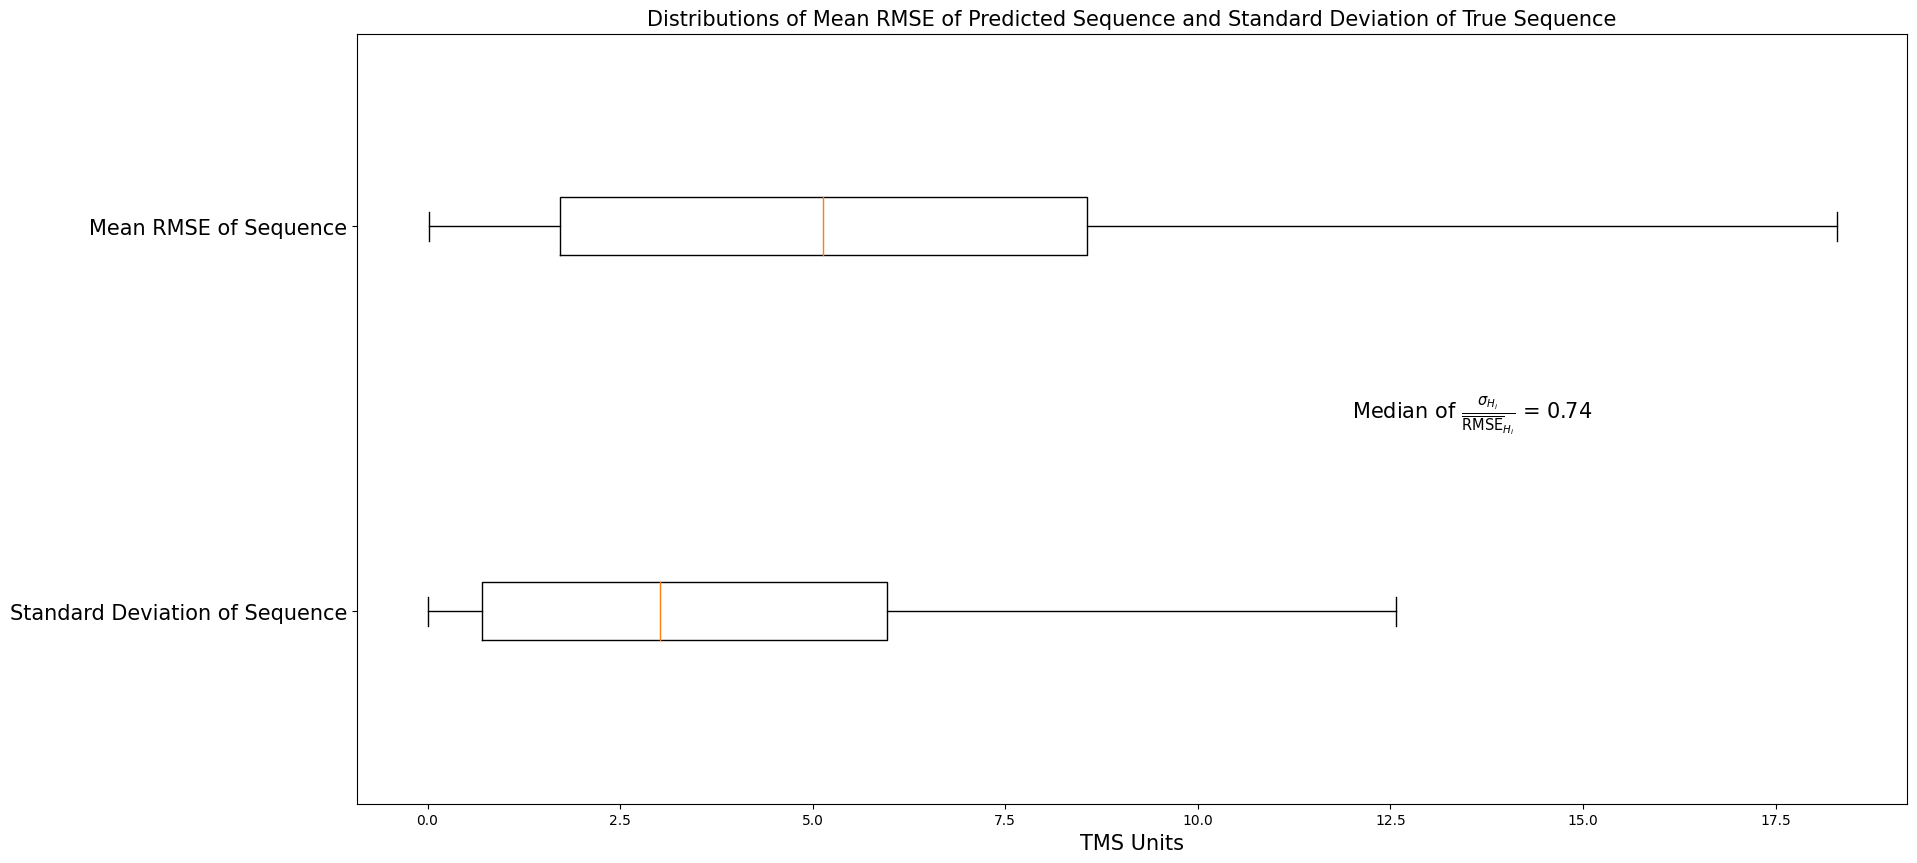

In [ ]:
patient_level_results
patient_sd = []
patient_avg_rms = []

for k in patient_level_results:
  patient_sd.append(np.std(patient_level_results[k]['all_tms'][SEQUENCE_SIZE:]))
  patient_avg_rms.append(np.sqrt(np.mean(patient_level_results[k]['sqdev'])))

patient_sd = np.array(patient_sd)
patient_avg_rms = np.array(patient_avg_rms)

nonzero_idx = np.where(patient_sd != 0)
patient_nonzero_rms_sd_ratio =  patient_sd[nonzero_idx] / patient_avg_rms[nonzero_idx]
rms_sd_ratio_median = np.round(np.median(patient_nonzero_rms_sd_ratio), 2)

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
ax.boxplot([patient_sd, patient_avg_rms], vert=False, showfliers=False);
ax.set_xlabel('TMS Units', size = 15)
ax.set_yticklabels(['Standard Deviation of Sequence', 'Mean RMSE of Sequence'], fontsize = 15);
ax.set_title('Distributions of Mean RMSE of Predicted Sequence and Standard Deviation of True Sequence', size = 15)
ax.text(12, 1.5, r'Median of $\frac{\sigma_{H_i}}{\overline{\mathrm{RMSE}}_{H_i}}$ = %.2f' % rms_sd_ratio_median, size = 15)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mean ratio between mean RMS of trajectory and SD of trajectory: 1.3692681346498983
Median ratio between mean RMS of trajectory and SD of trajectory: 1.3001174020641817


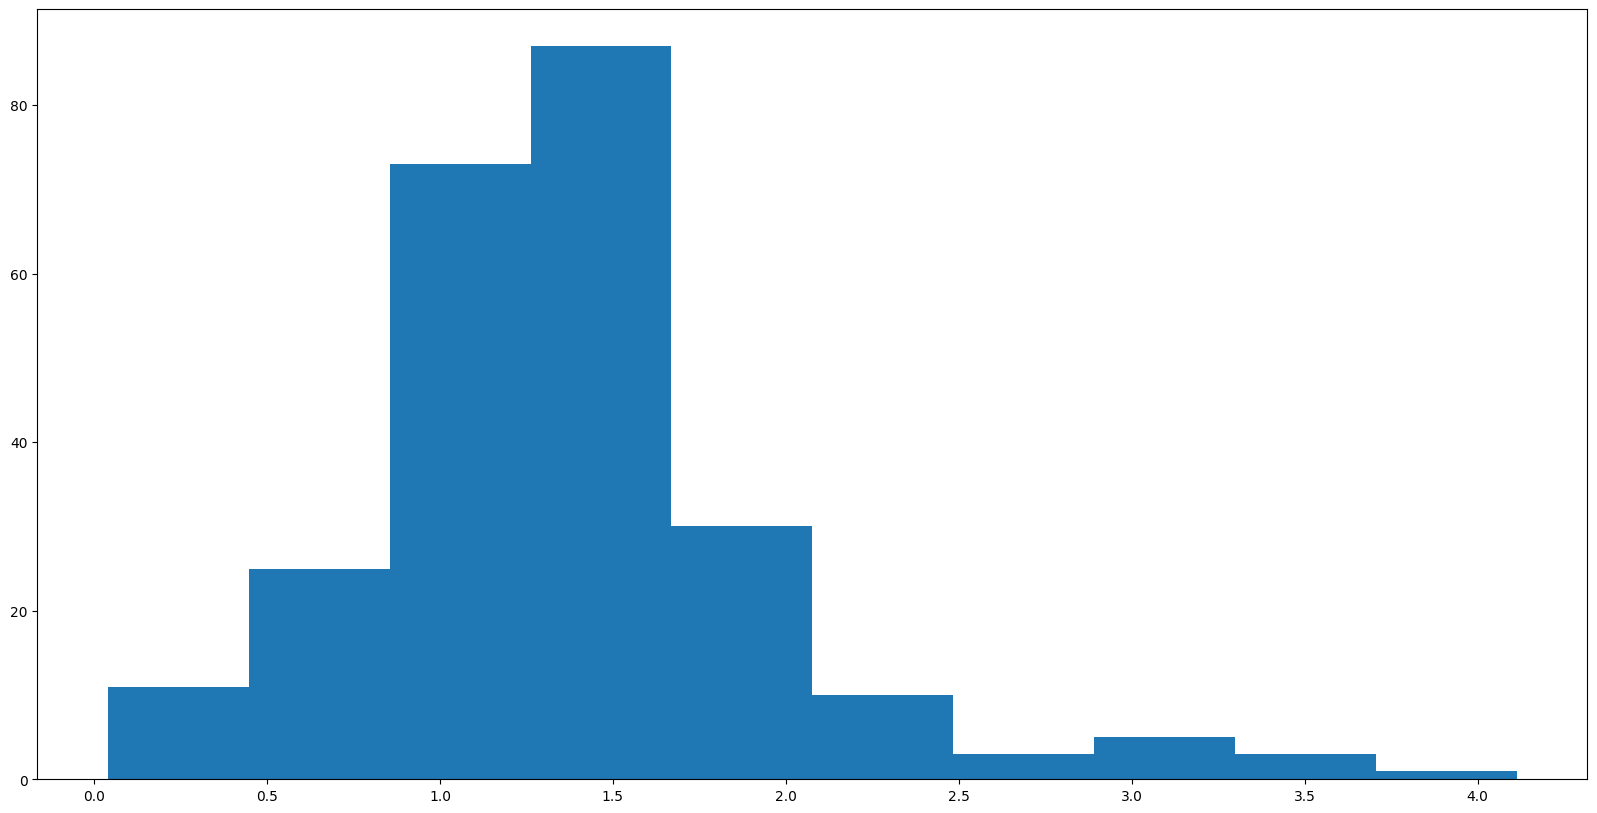

In [ ]:
# For trajetories with nonzero standard deviation, we can look at the ratio between the mean rms of the
# trajectory and the standard deviation

nonzero_idx = np.where(patient_sd != 0)
patient_nonzero_rms_sd_ratio = patient_avg_rms[nonzero_idx] / patient_sd[nonzero_idx]
print(f"Mean ratio between mean RMS of trajectory and SD of trajectory: {np.mean(patient_nonzero_rms_sd_ratio)}")
print(f"Median ratio between mean RMS of trajectory and SD of trajectory: {np.median(patient_nonzero_rms_sd_ratio)}")

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
ax.hist(patient_nonzero_rms_sd_ratio);

# Notice we are around 1, but roughly 25-30% higher... matches percent error

In [ ]:
# Notes:
# 4-2 Looks like remasking epoch interval could increase, training peaks not flattening out
# Accuracy plot shows that model worse at predicting higher TMS

# 4-20
  # Removing TMS from input sequence hurts model performance
    # (intuitively, one might think the reduction in dimensionality would help, but
    # perhaps the model isn't learning the relationship sum(MDS-UPDRS-III scores) == TMS)
  # Using 80-20 training-test split improves performance
  # Adding a fourth layer, want to compare performance

In [ ]:
#### Data visualization for final project report ####
MIN_VISITS = 1
# Read in MDS-UPDRS Part III (motor assessment) dataset
mds3_df = pd.read_csv("/content/drive/MyDrive/SDS492/Motor___MDS-UPDRS/MDS-UPDRS_Part_III_09Jan2024.csv")
# Read in subject demographic dataset
demo_df = pd.read_csv("/content/drive/MyDrive/SDS492/_Subject_Characteristics(1)/Demographics_09Jan2024.csv")
# Select subject identifier, birthdate and sex
age_sex_df = demo_df[['PATNO', 'BIRTHDT', 'SEX']]

# Filter for date less than 12/2022 (meaning all remaining patients, if they went to all visits, should have at least five recorded, since max date is 1/8/2024)
select = mds3_df[['PATNO', 'EVENT_ID', 'INFODT']]
select_bl = select[select['EVENT_ID'] == 'BL']
select_bl['INFODT'] = pd.to_datetime(select_bl['INFODT'])
date_filtered_patnos = select_bl[select_bl['INFODT'] < '2019-04-01']['PATNO']
date_filtered_df = mds3_df[mds3_df['PATNO'].isin(date_filtered_patnos)]

df3 = join_and_clean_datasets(date_filtered_df, demo_df, age_sex_df, MIN_VISITS)

# Group by years since BL, length of group is number of expected visits, length of group where np3tot not -1 is number of completed visits
grouped = df3[['PATNO', 'YEARS_SINCE_BL', 'NP3TOT']].groupby(by = 'YEARS_SINCE_BL')
visits_prop_dict = {}

for name, df in grouped:
  prop = len(df[df['NP3TOT'] != -1.0]) / len(df)
  visits_prop_dict[float(name)] = prop


fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(6)


ax.bar(range(len(visits_prop_dict)), list(visits_prop_dict.values()), align='center', color = 'blue');
for i, v in enumerate(list(visits_prop_dict.values())):
    ax.text(i, v+0.005, str(round(v, 2)), color='blue', fontweight='bold', horizontalalignment='center', size = 18)
ax.set_xticks(range(len(visits_prop_dict)), list(visits_prop_dict.keys()));
ax.set_xlabel('Time since baseline (years)', size = 18)
ax.set_ylabel('Proportion of expected visits attended', size = 18)
ax.set_title('Ratio of Number of Visits Attended to Number of PPMI Scheduled Visits', size = 18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-46-f50cc4a78e60>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  select_bl['INFODT'] = pd.to_datetime(select_bl['INFODT'])
<ipython-input-46-f50cc4a78e60>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_bl['INFODT'] = pd.to_datetime(se

{0.0: 0.9986197377501725,
 0.25: 0.34851621808143546,
 0.5: 0.6991028295376122,
 0.75: 0.31262939958592134,
 1.0: 0.8771566597653554,
 1.5: 0.6922015182884748,
 2.0: 0.7881297446514838,
 2.5: 0.5417529330572809,
 3.0: 0.6935817805383023,
 3.5: 0.4306418219461698,
 4.0: 0.6418219461697723,
 4.5: 0.3146997929606625,
 5.0: 0.5748792270531401}

In [ ]:
min_visit_range = range(1, 13)

min_visit_dict = {}

for n in min_visit_range:
  # Read in MDS-UPDRS Part III (motor assessment) dataset
  mds3_df = pd.read_csv("/content/drive/MyDrive/SDS492/Motor___MDS-UPDRS/MDS-UPDRS_Part_III_09Jan2024.csv")
  # Read in subject demographic dataset
  demo_df = pd.read_csv("/content/drive/MyDrive/SDS492/_Subject_Characteristics(1)/Demographics_09Jan2024.csv")
  # Select subject identifier, birthdate and sex
  age_sex_df = demo_df[['PATNO', 'BIRTHDT', 'SEX']]

  df = join_and_clean_datasets(mds3_df, demo_df, age_sex_df, n)

  n_patients = len(df['PATNO'].unique())
  min_visit_dict[n] = n_patients


fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(6)


ax.bar(range(len(min_visit_dict)), list(min_visit_dict.values()), align='center', color = 'blue');
ax.set_xticks(range(len(min_visit_dict)), list(min_visit_dict.keys()));
for i, v in enumerate(list(min_visit_dict.values())):
    ax.text(i, v + 10, str(v), color='blue', fontweight='bold', horizontalalignment='center', size = 18)
ax.set_xlabel('Minimum number of visits attended', size = 18)
ax.set_ylabel('Number of patients', size = 18)
ax.set_title('Number of Patients in Dataset After Filtering for Minimum Number of Visits Attended', size = 18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-8-716a05e44cf6>:72: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  birthday_dict = dict(zip(age_sex_df.PATNO, pd.to_datetime(age_sex_df.BIRTHDT)));
<ipython-input-8-716a05e44cf6>:75: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bldate_dict = dict(zip(patno_bldate.PATNO, pd.to_datetime(patno_bldate.EXAMDT)));
<ipython-input-8-716a05e44cf6>:72: UserW